Så først og fremmest få prio grid og UCDP merged og se hvad su så synes du mangler...

In [1]:
import numpy as np
from scipy import stats

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import seaborn as sns

import math
import time

from shapely.geometry import Point

full_script_time = time.time()

Gelman siger (måske): divider dine continuerlige variabler med 2 std_d for at de kommer til at ligene dine katagoriske var mere.... (https://www.youtube.com/watch?v=Jb9eklfbDyg 16.30)

In [2]:
def import_df():
    """Function for loading, handling and merging the data. Rigth now you don't use the prio gird thou.."""
    t1 = time.time()
    
    # load data:
    prio_grid = gpd.read_file("zip:///home/polichinel/Dropbox/KU/9.semester/friopgave/data/prio_grid/priogrid_cellshp.zip")
    prio_static = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/prio_grid/static/PRIO-GRID Static Variables - 2018-08-21.csv")
    prio_yearly_interp = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/prio_grid/yearly/PRIO_Yearly_interp.csv")
    prio_yearly = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/prio_grid/yearly/PRIO-GRID Yearly Variables for 1946-2014 - 2018-08-21.csv")
    ucdp = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/upsala/ged181.csv")# the error is not importent as you do not use that feature 
    
    ucdp =  ucdp[ucdp['gwnob'].isna()] # only conflicts NOT between to stats
    
    # Choosing ("most") relevant variables:
    prio_grid_lean = prio_grid[['gid','geometry']]
    prio_static_lean = prio_static[['gid','landarea','ttime_mean','mountains_mean','petroleum_s']]
    prio_yearly_interp_lean = prio_yearly_interp[['gid','year','interp_pop_gpw_sum','interp_gcp_ppp','interp_urban_ih','interp_agri_ih','interp_forest_ih']]
    prio_yearly_lean = prio_yearly[['gid','year','gwno','gwarea','bdist1','bdist3','capdist','excluded','petroleum_y','nlights_calib_mean']] #bdist 3 er minimere nans
    ucdp_lean = ucdp[['priogrid_gid','country_id','region','year','best']]

    
    # Choosing relevant years: 
    prio_yearly_interp_lean_1990 = prio_yearly_interp_lean[(prio_yearly_interp_lean['year'] >= 1990) & (prio_yearly_interp_lean['year'] <= 2010)]
    prio_yearly_lean_1990 = prio_yearly_lean[(prio_yearly_lean['year'] >= 1990) & (prio_yearly_lean['year'] <= 2010)]
    ucdp_lean_1990 = ucdp_lean[(ucdp_lean['year'] >= 1990) & (ucdp_lean['year'] <= 2010)]
    
    # Aggregating yearly fatalities:
    ucdp_lean_1990_year_agg = ucdp_lean_1990.groupby(by=['priogrid_gid','country_id','year']).sum().reset_index() # det her virker.tror jeg
    ucdp_lean_1990_year_agg.rename(columns={'priogrid_gid':'gid'}, inplace=True)
    ucdp_lean_1990_year_agg.rename(columns={'country_id':'gwno'}, inplace=True)
    
    
    # Merging
    prio_yearly_lean_1990_all = pd.merge(prio_yearly_interp_lean_1990, prio_yearly_lean_1990, on = ['gid','year'])

    prio_static_grid = prio_grid_lean.merge(prio_static_lean, on='gid', how='inner')
    prio_sy_grid = prio_static_grid.merge(prio_yearly_lean_1990_all, on = 'gid', how='inner')
    prio_sy_ucdp_grid = prio_sy_grid.merge(ucdp_lean_1990_year_agg, on = ['gid','year','gwno'], how='left')

    
    # Filling in cells with non-fatalities.
    prio_sy_ucdp_grid['best'].fillna(value=0, inplace = True)
    prio_sy_ucdp_grid['log_best'] = np.log(prio_sy_ucdp_grid['best']+1)
    
    # Managing petolium:
    prio_sy_ucdp_grid['petroleum_y'] = prio_sy_ucdp_grid.sort_values('year').groupby('gid')['petroleum_y'].fillna(method = 'ffill').copy() # fint
    prio_sy_ucdp_grid['petroleum_y'].fillna(0, inplace = True)
    prio_sy_ucdp_grid['petroleum_s'].fillna(0, inplace = True)
    
    prio_sy_ucdp_grid['petroleum_full'] = np.maximum(prio_sy_ucdp_grid['petroleum_y'],prio_sy_ucdp_grid['petroleum_s'])
    
    prio_sy_ucdp_grid.drop('petroleum_y', axis=1, inplace=True)
    prio_sy_ucdp_grid.drop('petroleum_s', axis=1, inplace=True)
                                                        
    # Managing bdist1 
    #prio_sy_ucdp_grid['bdist1'].fillna(np.median(prio_sy_ucdp_grid['bdist1']), inplace = True) # kunne være fedt bare at ordne det i modellen.
    
    df_done = prio_sy_ucdp_grid[prio_sy_ucdp_grid['gwno'].notna()] # removes 12 fucks.
    
    print('seconds it took load and handle data: ' + str(time.time()-t1))
    return(df_done) # ucdp for dist. to conflict var.
    
    # Should you normelize the data... espec teh y 'best'

In [3]:
def import_df_point():
    
    t1 = time.time()
    ucdp = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/upsala/ged181.csv")# the error is not importent as you do not use that feature 

    ucdp =  ucdp[ucdp['gwnob'].isna()] # only conflicts NOT between to stats

    ucdp_1990 = ucdp[(ucdp['year'] >= 1990) & (ucdp['year'] <= 2010)]

    ucdp_1990_year_agg = ucdp_1990.groupby(by=['priogrid_gid','country_id','year', 'latitude', 'longitude']).sum().reset_index() # det her virker.tror jeg
    ucdp_1990_year_agg.rename(columns={'priogrid_gid':'gid'}, inplace=True)
    ucdp_1990_year_agg.rename(columns={'country_id':'gwno'}, inplace=True)

    ucdp_lean_1990_year_agg = ucdp_1990_year_agg[['gid','gwno','year','best']]

    ucdp_1990_year_agg['Coordinates'] = list(zip(ucdp_1990_year_agg.longitude, ucdp_1990_year_agg.latitude))
    ucdp_1990_year_agg['Coordinates'] = ucdp_1990_year_agg['Coordinates'].apply(Point)

    gdf_point = gpd.GeoDataFrame(ucdp_1990_year_agg, geometry='Coordinates')

    print('seconds it took load and handle data: ' + str(time.time()-t1))
    return(gdf_point) # ucdp for dist. to conflict var.

    

In [4]:
df = import_df() # df_pint = ucdp for dist. to conflict var.
df_point = import_df_point()

# Hvad bruger du den til?
feature_list = ['landarea', 'ttime_mean', 'mountains_mean',
       'petroleum_full', 'year', 'interp_pop_gpw_sum', 'interp_gcp_ppp',
       'interp_urban_ih', 'interp_agri_ih', 'interp_forest_ih', 'gwno',
       'gwarea','bdist1', 'bdist3', 'capdist', 'excluded', 'nlights_calib_mean', 'best']

df.shape


/home/polichinel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


seconds it took load and handle data: 114.36892414093018


/home/polichinel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


seconds it took load and handle data: 4.044646263122559


(1361166, 21)

In [5]:
df = df[df['gwno'].notna()] # removes 12 fucks.
df.shape

(1361166, 21)

In [6]:
def get_na(df=df):

    na_list = []
    
    for i in df.columns:
        proporiton_na = df[i].isna().sum()/len(df[i])
        print(i + " that is NA : " + str(round(proporiton_na*100, 3)) + '%')
        
        
        
        if proporiton_na > 0.01:
            na_list.append(i)
        
    return(na_list)

In [7]:
def fill_missing_1(df=df):
    
    # First back-extrapolating light values from 1992 to 91 and 90.
    
    Light_years = [1990, 1991]# full missing years for 'nlights_calib_mean'.
    missing_list = ['interp_urban_ih', 'interp_agri_ih', 'interp_forest_ih','mountains_mean','nlights_calib_mean']
    
    for y in Light_years:
        df.loc[df['year'] == y, 'nlights_calib_mean'] = df[df['year'] == 1992]['nlights_calib_mean'].values


    for f in missing_list:
        df.loc[df[f] < 0 , f] = 0 # due to rounding errors in the interpolation, few values a negative (still practical zero.)
    
        df[f].fillna(df[f].min(), inplace = True) # minimun in this case being zero.

fill_missing_1()

def fill_missing_2(df=df):
    
    # first bdist1:
    df['bdist1'].fillna(df['bdist1'].median(), inplace = True) # median and not mean, since it is is skewed - ofc should be corss-validated. 
    
    # Then, correct the interpolation:
    df.loc[df['interp_gcp_ppp'] < 0 , 'interp_gcp_ppp'] = 0 # due to rounding errors in the interpolation, few values a negative (still practical zero.)
    
    # fill forward:
    df['interp_gcp_ppp'] = df.sort_values('year').groupby('gid')['interp_gcp_ppp'].fillna(method = 'ffill')
    df['interp_gcp_ppp'] = df.sort_values('year').groupby('gid')['interp_gcp_ppp'].fillna(method = 'bfill')

    
    # Excluded = min
    df['excluded'].fillna(df['excluded'].min(), inplace = True) # tjek lige i codebogen om det her er khoser
    
    
fill_missing_2()
na_list = get_na()

gid that is NA : 0.0%
geometry that is NA : 0.0%
landarea that is NA : 0.0%
ttime_mean that is NA : 0.156%
mountains_mean that is NA : 0.0%
year that is NA : 0.0%
interp_pop_gpw_sum that is NA : 0.0%
interp_gcp_ppp that is NA : 2.057%
interp_urban_ih that is NA : 0.0%
interp_agri_ih that is NA : 0.0%
interp_forest_ih that is NA : 0.0%
gwno that is NA : 0.0%
gwarea that is NA : 0.0%
bdist1 that is NA : 0.0%
bdist3 that is NA : 0.0%
capdist that is NA : 0.0%
excluded that is NA : 0.0%
nlights_calib_mean that is NA : 0.0%
best that is NA : 0.0%
log_best that is NA : 0.0%
petroleum_full that is NA : 0.0%


Some justifications...

Of course, this hold 'missing vaules' inter/extrapolation ecxercise should under all surcomstances be performet under cross validation and would no doubt benifit from being traeated as a predictive problem in it self. I will show how to incoporate the laste few missing values in the model, and if time permits go back and test different approches. For now, this will serve, and if I do not find the time to go back this will be a challenge for the next project. 


**Så hvad nu?**

# C-shape dict (cool, but why?)

In [8]:
def my_import_2():
    cshapes = gpd.read_file("zip:////home/polichinel/Dropbox/KU/9.semester/friopgave/data/CShapes/cshapes_0.6.zip")
    cshapes.rename(columns={'CNTRY_NAME':'country_name','COWCODE':'gwno'}, inplace=True)
    cshapes_lean = cshapes[['country_name','gwno']]

    return(cshapes_lean)

cshapes_lean = my_import_2()
    
def country_lookup(gwno):
    if len(cshapes_lean[cshapes_lean['gwno'] == gwno]['country_name']) != 0:
        country_name = cshapes_lean[cshapes_lean['gwno'] == gwno]['country_name'].iloc[0]
        print(country_name)
    else:
        print('unknown gwno')
        
        
def country_lookup_out(gwno):
    
    c_list = []
    
    if len(cshapes_lean[cshapes_lean['gwno'] == gwno]['country_name']) != 0:
        country_name = cshapes_lean[cshapes_lean['gwno'] == gwno]['country_name'].iloc[0]
        c_list.append(country_name)
    else:
        c_list.append('unknown gwno')
        
    return(c_list)

In [9]:
country_lookup(1)

unknown gwno


In [10]:
country_lookup(2)

United States


Kan du få lande sørelse in her? du kan self også bare aggregere area på gwno og year...

Så det ser fint ud neden for, men du skal stadigt havde styr på olie og dine imputationer. Lige nu tror jeg du sætter alt til nul.. Det går ikke.. Det kan du gøre med best. Og måske et par andre, men det skal være gennemtænkt.

# Some light feature eginering:

### the y's:

In [12]:
# Creating the binary target:
df['binary_best'] = pd.Series(df['best'] > 0).astype('int') 

# Leading the binary target:
df['lead_binary_best'] = df.sort_values('year').groupby(['gid'])['binary_best'].shift(-1)

# Lead best
df['lead_best'] = df.sort_values('year').groupby(['gid'])['best'].shift(-1)

# Past fatalities
df['past_fatalities'] = df.sort_values('year').groupby(['gid'])['best'].cumsum()

#df['log_past_fatalities'] = np.log(df['past_fatalities'] + 1) # ordner du senere!

# Past conflicts
df['past_conflicts'] = df.sort_values('year').groupby(['gid'])['binary_best'].cumsum()

# Years since peace/conflict is handled defferently... later on

# Fatilities/conflict in country

df['fatilities_country_year'] = df.groupby(['gwno','year'])['best'].transform(np.sum)
df['conflict_country_year'] = np.array(df['fatilities_country_year'] > 0).astype(int)

In [ ]:
## Works, but takes to long du to no cython implimentation

# def min_distance():

#     t1 = time.time()

#     dist_list = []

#     for i in range(df.shape[0]):
#         D = df_point['Coordinates'].distance(df['geometry'][i].centroid) # centroid for at spare tid.
#         dist_list.append(D.min())    

#     print('seconds it took load and handle data: ' + str(time.time()-t1))

#     return(dist_list)
    
# df['dist_to_conflict'] = min_distance()

# DIST TEST:

In [13]:
# # single pros

# t1 = time.time()

# years = np.arange(1990,1999)


# def get_dist(years = years):

#     sub_dict = {}

#     for y in years:
#         subset = df[df['year']==1990][:100].copy()
#         subset_point = df_point[df_point['year']==1990][:100].copy()

#         subset_name = 'subset_' + str(y)

#         subset['dist_nearest_conflict'] = [subset_point['Coordinates'].distance(subset['geometry'].iloc[i].centroid).min() for i in range(100)]

#         sub_dict[subset_name] = subset
    
#     return(sub_dict)


# sub_dict = get_dist(years)

# hours = (((time.time()-t1) * 14000)/60)/60

# print('hours it will take: ' + str(hours))

hours it will take: 6.892639398574829


In [61]:
t1 = time.time()

output = mp.Queue()

years = [1990,1991,1992,1993,1994,1995,1996,1997]
sub_dict = {}

def print_years(x,output):
    
    year = years[x]
    
    subset = df[df['year']==year][:100].copy()
    subset_point = df_point[df_point['year']==year][:100].copy()
    
    dist_nearest_conflict_list = [subset_point['Coordinates'].distance(subset['geometry'].iloc[i].centroid).min() for i in range(100)]
    
    output.put(dist_nearest_conflict_list)

processes = [mp.Process(target=print_years, args=(x, output)) for x in range(8)]

# Run processes
for p in processes:
    p.start()

# Exit the completed processes
for p in processes:
    p.join()
    
# Get process results from the output queue
results = [output.get() for p in processes]

hours = (((time.time()-t1) * 1750)/60)/60

print('hours it will take: ' + str(hours))

hours it will take: 0.37368526061375934


In [77]:
# with processes

t0 = time.time()

output = mp.Queue()

years = [1990,1991,1992,1993,1994,1995,1996,1997]
sub_dict = {}

def print_years(x,output):
    
    year = years[x]
    
    subset = df[df['year']==year][:280].copy()
    subset_point = df_point[df_point['year']==year][:280].copy()
    
    dist_nearest_conflict_list = [subset_point['Coordinates'].distance(subset['geometry'].iloc[i].centroid).min() for i in range(280)]
    
    output.put(dist_nearest_conflict_list)

processes = [mp.Process(target=print_years, args=(x, output)) for x in range(8)]

# Run processes
for p in processes:
    p.start()

# Exit the completed processes
for p in processes:
    p.join()
    
# Get process results from the output queue
results_1990_1997 = [output.get() for p in processes]

t1 = time.time()-t0

print('minutes it took: ' + str(t1/60))

minutes it took: 0.046702746550242105


In [122]:
# with pool:
t0 = time.time()

#years = [1990,1991,1992,1993,1994,1995,1996,1997]
years = np.arange(1990,2011)

sub_dict = {}

def print_years(x):
    
    year = years[x]
    
    subset = df[df['year']==year][:100].copy()
    subset_point = df_point[df_point['year']==year][:100].copy()
    
    dist_nearest_conflict_list = [subset_point['Coordinates'].distance(subset['geometry'].iloc[i].centroid).min() for i in range(100)]
    
    return(dist_nearest_conflict_list)

# processes = [mp.Process(target=print_years, args=(x, output)) for x in range(8)]

# # Run processes
# for p in processes:
#     p.start()

# # Exit the completed processes
# for p in processes:
#     p.join()
    
# # Get process results from the output queue
# results_1990_1997 = [output.get() for p in processes]

pool = mp.Pool(processes=8)
#results = [pool.apply_async(print_years, args=(x,)) for x in range(8)]
results = [pool.apply_async(print_years, args=(x,)) for x in range(years.shape[0])]

output = [p.get() for p in results]
#print(results)

t1 = time.time()-t0
print('minutes it took: ' + str(t1/60))

minutes it took: 0.2948174675305684


Process ForkPoolWorker-627:
Process ForkPoolWorker-628:
Process ForkPoolWorker-626:
Process ForkPoolWorker-623:
Process ForkPoolWorker-622:
Process ForkPoolWorker-629:
Traceback (most recent call last):
Process ForkPoolWorker-625:
Process ForkPoolWorker-624:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/polichinel/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/polichinel/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/polichinel/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/polichinel/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/polichinel/ana

In [127]:
# with pool:
t0 = time.time()

years = np.arange(1990,2011)

def print_years(x):
    
    year = years[x]
    
    subset = df[df['year']==year].copy()
    subset_point = df_point[df_point['year']==year].copy()
    
    dist_nearest_conflict_list = [subset_point['Coordinates'].distance(subset['geometry'].iloc[i].centroid).min() for i in range(subset.shape[0])]
    
    return(dist_nearest_conflict_list)


pool = mp.Pool(processes=8)
results = [pool.apply_async(print_years, args=(x,)) for x in range(years.shape[0])]

output = [p.get() for p in results]

t1 = time.time()-t0
print('minutes it took: ' + str(t1/60))

minutes it took: 248.45003904104232


Process ForkPoolWorker-633:
Process ForkPoolWorker-630:
Process ForkPoolWorker-637:
Traceback (most recent call last):
Process ForkPoolWorker-636:
Process ForkPoolWorker-631:
Traceback (most recent call last):
Process ForkPoolWorker-635:
Process ForkPoolWorker-634:
Traceback (most recent call last):
Process ForkPoolWorker-632:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/polichinel/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/polichinel/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/polichinel/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/polichinel/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/polichinel/anaconda3/lib/python3.6/multiprocessing/process.py

In [142]:
def make_df_dict():
    
    df_dict = {}
        
    for i in range(years.shape[0]):
    
        year = years[i]
    
        subset = df[df['year']==year].copy()
        
        subset['nearest_conflict'] = output[i]
    
        df_name = 'subset_' + str(year) 
    
        df_dict[df_name]  = subset
    
    return(df_dict)

In [144]:
df_dict = make_df_dict()

In [147]:
df_dict['subset_2010'].shape

(64818, 29)

In [171]:
df = pd.concat([df_dict['subset_1990'],
                df_dict['subset_1991'],
                df_dict['subset_1992'],
                df_dict['subset_1993'],
                df_dict['subset_1994'],
                df_dict['subset_1995'],
                df_dict['subset_1996'],
                df_dict['subset_1997'],
                df_dict['subset_1998'],
                df_dict['subset_1999'],
                df_dict['subset_2000'],
                df_dict['subset_2001'],
                df_dict['subset_2002'],
                df_dict['subset_2003'],
                df_dict['subset_2004'],
                df_dict['subset_2005'],
                df_dict['subset_2006'],
                df_dict['subset_2007'],
                df_dict['subset_2008'],
                df_dict['subset_2009'],
                    df_dict['subset_2010']])

In [165]:
#full_df.to_file('full_df') # to file ->  it is a geopandas df! -> or just pickle it...

### Low and high ratios from Cederman, Gleditsch and Buhaug. p 105
Should be vectorized and mad into one function:

Mean kan vel også bruges som et relative mål for landet i forhold til andre lande?

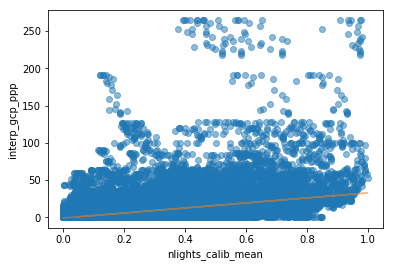

Slope: 33.7
Standart Error: 0.0446
P-value: 0.0
R²: 0.31


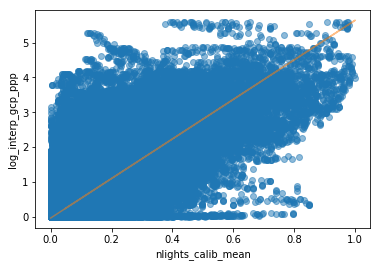

Slope: 5.67
Standart Error: 0.00436
P-value: 0.0
R²: 0.571


In [173]:
# show the corrolation between light and gcp:

def wealth_corr(df=df):

    data = df.dropna()

    # normal:
    x = data['nlights_calib_mean']
    y = data['interp_gcp_ppp']

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept
    plt.plot(x,y,'o', x, line, alpha = 0.5)
        
    # ---------------------
    plt.xlabel('nlights_calib_mean')
    plt.ylabel('interp_gcp_ppp')
        
    plt.show()
    print('Slope: {:.3}\nStandart Error: {:.3}\nP-value: {:.3}\nR²: {:.3}'.format(slope, std_err, p_value,r_value**2))

    # log gcp:
    x = data['nlights_calib_mean']
    y = np.log(data['interp_gcp_ppp'] +1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept
    plt.plot(x,y,'o', x, line, alpha = 0.5)
        
    # ---------------------
    plt.xlabel('nlights_calib_mean')
    plt.ylabel('log_interp_gcp_ppp')
        
    plt.show()
    print('Slope: {:.3}\nStandart Error: {:.3}\nP-value: {:.3}\nR²: {:.3}'.format(slope, std_err, p_value,r_value**2))
    
    
wealth_corr()

## Der er et problem med alle nullerne i gcp. 
Det kan jo ikke passe at folk producere ingen ting.. Har du imputed noget eller er det sådan fra starten? og det er jo faktisk selvom der er ret lyst... Du skal helt sikkert overveje at droppe den..

In [12]:
# But shoul you then log_tranform GCP before the interactions? As fare as I can tell that is not what cederman and gang does..

In [13]:
# MANGLER DU IKKE YEAR???

In [14]:
# # FOR light:

# # Create vector of means
# df['mean_light'] = df.groupby(['gwno'])['nlights_calib_mean'].transform(np.mean) # this shit! Måske netop np.where herfra..

# # Create vector base low_ratio (for now called low...)
# df['low_ratio_light'] = (df[df['nlights_calib_mean'] < df['mean_light']]['mean_light']+1) / (df[df['nlights_calib_mean'] < df['mean_light']]['nlights_calib_mean']+1) # +1 tt avoid /0
# df.loc[df['nlights_calib_mean'] >= df['mean_light'],'low_ratio_light'] = 1

# # Create vector base high_ratio (for now called high...)
# df['high_ratio_light'] = df[df['nlights_calib_mean'] > df['mean_light']]['nlights_calib_mean'] / df[df['nlights_calib_mean'] > df['mean_light']]['mean_light']
# df.loc[df['nlights_calib_mean'] <= df['mean_light'],'high_ratio_light'] = 1

In [174]:
# FOR light (WITH YEAR!!):

# Create vector of means
# Den strafffer lande med mange tyndt eller ubeboet celler...

df['mean_light'] = df.groupby(['gwno','year'])['nlights_calib_mean'].transform(np.mean) # this shit! Måske netop np.where herfra..

# Create vector base low_ratio (for now called low...)
df['low_ratio_light'] = (df[df['nlights_calib_mean'] < df['mean_light']]['mean_light']+1) / (df[df['nlights_calib_mean'] < df['mean_light']]['nlights_calib_mean']+1) # +1 tt avoid /0
df.loc[df['nlights_calib_mean'] >= df['mean_light'],'low_ratio_light'] = 1

# Create vector base high_ratio (for now called high...)
df['high_ratio_light'] = df[df['nlights_calib_mean'] > df['mean_light']]['nlights_calib_mean'] / df[df['nlights_calib_mean'] > df['mean_light']]['mean_light']
df.loc[df['nlights_calib_mean'] <= df['mean_light'],'high_ratio_light'] = 1

In [16]:
# # FOR GCP:

# # Create vector of means
# df['mean_gcp'] = df.groupby(['gwno'])['interp_gcp_ppp'].transform(np.mean) # this shit! Måske netop np.where herfra..

# # Create vector base low_ratio (for now called low...)
# df['low_ratio_gcp'] = (df[df['interp_gcp_ppp'] < df['mean_gcp']]['mean_gcp']+1) / (df[df['interp_gcp_ppp'] < df['mean_gcp']]['interp_gcp_ppp']+1) # +1 tt avoid /0
# df.loc[df['interp_gcp_ppp'] >= df['mean_gcp'],'low_ratio_gcp'] = 1

# # Create vector base high_ratio (for now called high...)
# df['high_ratio_gcp'] = df[df['interp_gcp_ppp'] > df['mean_gcp']]['interp_gcp_ppp'] / df[df['interp_gcp_ppp'] > df['mean_gcp']]['mean_gcp']
# df.loc[df['interp_gcp_ppp'] <= df['mean_gcp'],'high_ratio_gcp'] = 1

In [175]:
# FOR GCP(WITH YEAR!!):

# Create vector of means
# Den strafffer lande med mange tyndt eller ubeboet celler...
df['mean_gcp'] = df.groupby(['gwno','year'])['interp_gcp_ppp'].transform(np.mean) # this shit! Måske netop np.where herfra..

# Create vector base low_ratio (for now called low...)
df['low_ratio_gcp'] = (df[df['interp_gcp_ppp'] < df['mean_gcp']]['mean_gcp']+1) / (df[df['interp_gcp_ppp'] < df['mean_gcp']]['interp_gcp_ppp']+1) # +1 tt avoid /0
df.loc[df['interp_gcp_ppp'] >= df['mean_gcp'],'low_ratio_gcp'] = 1

# Create vector base high_ratio (for now called high...)
df['high_ratio_gcp'] = df[df['interp_gcp_ppp'] > df['mean_gcp']]['interp_gcp_ppp'] / df[df['interp_gcp_ppp'] > df['mean_gcp']]['mean_gcp']
df.loc[df['interp_gcp_ppp'] <= df['mean_gcp'],'high_ratio_gcp'] = 1

In [176]:
df[['high_ratio_light','low_ratio_light','high_ratio_gcp','low_ratio_gcp']].describe()

,high_ratio_light,low_ratio_light,high_ratio_gcp,low_ratio_gcp
count,1.361166e+06,1.361166e+06,1.333164e+06,1.333164e+06
mean,1.288303e+00,1.012347e+00,1.654332e+00,1.307266e+00
std,1.848843e+00,1.904707e-02,7.631091e+00,6.434020e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,1.000421e+00,1.000000e+00,1.019375e+00
50%,1.000000e+00,1.006108e+00,1.000000e+00,1.111704e+00
75%,1.000000e+00,1.014252e+00,1.000000e+00,1.271907e+00
max,2.696986e+02,1.352020e+00,7.454143e+02,1.522379e+01


### Make a few interactions: 

#### Skal du logge gcp før interactionerne.. Eller efter?

In [177]:
# binary excluded vriabel. Asking 'if', not 'how many'.
df['excluded_binary'] = pd.Series(df['excluded'] > 0).astype('int') # burde være rigtig.. men funky resultater ved df['excluded_low_ratio_light']

# # interaction with original excluded:
# df['excluded_nlights'] = (df['excluded']+1) / (df['nlights_calib_mean']+1) # my own implimentation
# df['excluded_gcp'] = (df['excluded']+1) / (df['interp_gcp_ppp']+1) # my own implimentation

# # interaction with binary excluded:
# df['excluded_b_nlights'] = (df['excluded_binary']+1) / (df['nlights_calib_mean']+1) # my own implimentation
# df['excluded_b_gcp'] = (df['excluded_binary']+1) / (df['interp_gcp_ppp']+1) # my own implimentation

# # Teoritisk set er denne her altså bedre...
# df['excluded_b_nlights_alt'] = (df['excluded_binary']) / (df['nlights_calib_mean']+1) # my own implimentation
# df['excluded_b_gcp_alt'] = (df['excluded_binary']) / (df['interp_gcp_ppp']+1) # my own implimentation

# # ------------------------------


# Cederman, Gledisch and Buhaug:

# binary:
df['excluded_b_low_ratio_gcp'] = df['low_ratio_gcp'] * df['excluded_binary']

df['excluded_b_high_ratio_gcp'] = df['high_ratio_gcp']* df['excluded_binary']

df['excluded_b_low_ratio_light'] = df['low_ratio_light'] * df['excluded_binary']

df['excluded_b_high_ratio_light'] = df['high_ratio_light']* df['excluded_binary']

# Original:
df['excluded_low_ratio_gcp'] = df['low_ratio_gcp'] * df['excluded']

df['excluded_high_ratio_gcp'] = df['high_ratio_gcp']* df['excluded']

df['excluded_low_ratio_light'] = df['low_ratio_light'] * df['excluded']

df['excluded_high_ratio_light'] = df['high_ratio_light']* df['excluded']


# Not really the same as Cederman, Gledisch and Buhaug. Assumes that the excluded groups size is some positive function of total size..
df['excluded_pop'] = df['excluded'] * df['interp_pop_gpw_sum']
df['excluded_b_pop'] = df['excluded_binary'] * df['interp_pop_gpw_sum']

# --------------------------------------------
# relative deprevation (my) + inter action:

# If poeple compare with the top
# country(and year) specific standart diviation * cell exculded (binary)

# if poeple compare with most(median):
# distance (count or std. d?) to (country_year) medain from cell median * cell exculded (Denne her er måske faktisk bedst..)

# Create vector of mediab

# LIGHT:---------------------------------------------------
# Den strafffer lande med mange tyndt eller ubeboet celler...

df['country_year_median_light'] = df.groupby(['gwno','year'])['nlights_calib_mean'].transform(np.median) # this shit! Måske netop np.where herfra..

df['diff_median_light'] = df['country_year_median_light'] - df['nlights_calib_mean'] # should make this stop at zero

df['diff_median_light_zero'] = df['diff_median_light']

df.loc[df['diff_median_light_zero'] <=0, 'diff_median_light_zero'] = 0



df['diff_median_light_excluded_b_zero'] = df['diff_median_light_zero'] * df['excluded_binary']

df['diff_median_light_excluded'] = df['diff_median_light'] * df['excluded']

df['diff_median_light_excluded_b'] = df['diff_median_light'] * df['excluded_binary']



#df['diff_median_light_excluded_b_zero'] = 

# GCP: ---------------------------------------------------------------------------
# Den strafffer lande med mange tyndt eller ubeboet celler...

df['country_year_median_gcp'] = df.groupby(['gwno','year'])['interp_gcp_ppp'].transform(np.median) # this shit! Måske netop np.where herfra..

df['diff_median_gcp'] = df['country_year_median_gcp'] - df['interp_gcp_ppp']


df['diff_median_gcp_zero'] = df['diff_median_gcp']

df.loc[df['diff_median_gcp_zero'] <=0, 'diff_median_gcp_zero'] = 0


df['diff_median_gcp_excluded_b_zero'] = df['diff_median_gcp_zero'] * df['excluded_binary']

df['diff_median_gcp_excluded'] = df['diff_median_gcp'] * df['excluded']

df['diff_median_gcp_excluded_b'] = df['diff_median_gcp'] * df['excluded_binary']

#df['diff_median_gcp_excluded_b_zero'] = 

# # Create vector base low_ratio (for now called low...)
# df['low_ratio_light'] = (df[df['nlights_calib_mean'] < df['mean_light']]['mean_light']+1) / (df[df['nlights_calib_mean'] < df['mean_light']]['nlights_calib_mean']+1) # +1 tt avoid /0
# df.loc[df['nlights_calib_mean'] >= df['mean_light'],'low_ratio_light'] = 1

# # Create vector base high_ratio (for now called high...)
# df['high_ratio_light'] = df[df['nlights_calib_mean'] > df['mean_light']]['nlights_calib_mean'] / df[df['nlights_calib_mean'] > df['mean_light']]['mean_light']
# df.loc[df['nlights_calib_mean'] <= df['mean_light'],'high_ratio_light'] = 1



# if people compare with mean:
# Distance (count or std. d?) to (country_year) mean from cell mean * cell excluded

# De to sidste kunne dog også lave med world mean and median? -> kommer fra Goldstone 2010.. Det er grund nok.


# Distance from (cell) median to (world/country/cell?) mean * excluded!


In [20]:
# done above...

# df['diff_median_light_excluded_b_zero'] = df['diff_median_light_excluded_b']  

# df.loc[df['diff_median_light_excluded_b_zero'] <0, 'diff_median_light_excluded_b_zero'] = 0

# df['diff_median_gcp_excluded_b_zero'] = df['diff_median_gcp_excluded_b']  

# df.loc[df['diff_median_gcp_excluded_b_zero'] <0, 'diff_median_gcp_excluded_b_zero'] = 0



### Country pop and size

In [178]:
# Virker fint

df['country_area_sum'] = df.groupby(['gwno','year'])['landarea'].transform(np.sum) # this shit! Måske netop np.where herfra..
df['country_pop_sum'] = df.groupby(['gwno','year'])['interp_pop_gpw_sum'].transform(np.sum) # this shit! Måske netop np.where herfra..


In [179]:
df[(df['gwno'] == 2 ) & (df['year'] == 2010)][['country_area_sum','country_pop_sum']].head() # passer på usa wiki areal og folke tælling 2010. ca.

,country_area_sum,country_pop_sum
65584,9.428286e+06,3.086483e+08
65605,9.428286e+06,3.086483e+08
65626,9.428286e+06,3.086483e+08
65647,9.428286e+06,3.086483e+08
65668,9.428286e+06,3.086483e+08


# pop dens country and cell:

In [180]:
# mass divided by volumen

df['pop_cell_dens'] = df['interp_pop_gpw_sum']/(df['landarea']+1) # men det her med 1 dur ikke..
df['pop_country_dens'] = df['country_pop_sum']/(df['country_area_sum']+1)

# interaction with excluded:

df['pop_cell_dens_excluded'] = df['pop_cell_dens'] * df['excluded']

df['pop_cell_dens_excluded_b'] = df['pop_cell_dens'] * df['excluded_binary']

# det med + 1 går nok ikke men det ser ellers fint ud...
# men der burde heller ikke være nogen med 0? og hvis der er gør +1 minimal forskel...

# Pop corrected variabeles:

**Kan du ikke bare dividere nlight-country-year-mean med country-pop???**

### Andre interaktion eller transformation fra litteraturen? 
**Overvej også at behandle best som en tidsserie og brug fremskrivningen som som variable - både count og slope. **
- Ja, men det er jo lidt det den kommende guassian process i modellen burde gøre... Right?

- Low and high ratio are effectivly inequality before the interaction.

- Hvad sker der for politisk system og infant mortality? Det bliver du nød til at snakke om... Politisk system måske med henvisning til at når man ikke bruger Polity IV har littereaturen ikke fundet meget... Infant mort fordi der kun er et år..

In [24]:
#  (interp\_pop\_gpw\_sum])[ned country pop and country dens.... and cell dens]

### Logs:
**Her skal der sorteres ud!!!** Men nye skal også in. igen er det nok lettest at lave en negtiv liste..

In [181]:
# New

def log_transformation(df = df):
    
    features_not_to_log = ['gid','geometry','year','gwno',
                           'excluded','petroleum_full','log_best','best']  # lead_binary_best
    # log_best already definded.. Men hvorfor har du gjort det?
    
    
    for feature in df.columns:
        
        if feature not in features_not_to_log:
    
            feature_name = 'log_' + feature
    
            df[feature_name] = np.log(df[feature] + 1)

log_transformation()

/home/polichinel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


In [182]:
df.describe()

,gid,landarea,ttime_mean,mountains_mean,year,interp_pop_gpw_sum,interp_gcp_ppp,interp_urban_ih,interp_agri_ih,interp_forest_ih,...,log_diff_median_gcp_zero,log_diff_median_gcp_excluded_b_zero,log_diff_median_gcp_excluded,log_diff_median_gcp_excluded_b,log_country_area_sum,log_country_pop_sum,log_pop_cell_dens,log_pop_country_dens,log_pop_cell_dens_excluded,log_pop_cell_dens_excluded_b
count,1.361166e+06,1.361166e+06,1.359045e+06,1.361166e+06,1.361166e+06,1.361166e+06,1.333164e+06,1.361166e+06,1.361166e+06,1.361166e+06,...,1.333164e+06,1.333164e+06,1.302411e+06,1.306694e+06,1.361166e+06,1.361166e+06,1.361166e+06,1.361166e+06,1.361166e+06,1.361166e+06
mean,1.744246e+05,2.036876e+03,1.187741e+03,2.400670e-01,2.000000e+03,9.318020e+04,7.070617e-01,2.611628e-01,9.266413e+00,2.002904e+01,...,4.137375e-02,1.324911e-02,-1.827307e-02,-1.858046e-02,1.504342e+01,1.784650e+01,1.788640e+00,2.913675e+00,5.489580e-01,5.270001e-01
std,4.581800e+04,8.691272e+02,1.690242e+03,3.599505e-01,6.055276e+00,3.593460e+05,4.173917e+00,1.699702e+00,1.835081e+01,3.245662e+01,...,1.582122e-01,6.074386e-02,2.239986e-01,2.173766e-01,1.561769e+00,1.595408e+00,1.845913e+00,1.261145e+00,1.264151e+00,1.211527e+00
min,4.918200e+04,2.559617e-06,5.123288e+00,0.000000e+00,1.990000e+03,-4.336809e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,-8.451499e+00,-8.451499e+00,3.342326e+00,8.564526e+00,0.000000e+00,8.987136e-01,0.000000e+00,0.000000e+00
25%,1.407950e+05,1.391276e+03,2.227483e+02,0.000000e+00,1.995000e+03,2.129668e+02,2.946746e-03,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.396928e+01,1.683403e+01,1.393197e-01,2.217514e+00,0.000000e+00,0.000000e+00
50%,1.842010e+05,2.195231e+03,5.082728e+02,0.000000e+00,2.000000e+03,4.085204e+03,2.414200e-02,0.000000e+00,1.900000e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.585695e+01,1.767185e+01,1.134751e+00,2.654585e+00,0.000000e+00,0.000000e+00
75%,2.129270e+05,2.818335e+03,1.483922e+03,4.500000e-01,2.005000e+03,4.235912e+04,2.333571e-01,0.000000e+00,8.200000e+00,3.051700e+01,...,9.114266e-03,0.000000e+00,0.000000e+00,0.000000e+00,1.610923e+01,1.881680e+01,3.059354e+00,3.689475e+00,1.469737e-01,1.463061e-01
max,2.493440e+05,3.091067e+03,3.003262e+04,1.000000e+00,2.010000e+03,1.827816e+07,2.646676e+02,7.811000e+01,1.000000e+02,1.000000e+02,...,3.187464e+00,2.061403e+00,2.587496e+00,2.061403e+00,1.690503e+01,2.102392e+01,1.184343e+01,9.064980e+00,9.493296e+00,9.493296e+00


In [27]:
# # old:

# def log_transformation(df = df):
    
#     features_to_log = ['landarea', 'ttime_mean', 'mountains_mean',
#                        'interp_pop_gpw_sum', 'interp_gcp_ppp', 'interp_urban_ih',
#                        'interp_agri_ih', 'interp_forest_ih', 'gwarea', 'bdist1',
#                        'bdist3', 'capdist', 'nlights_calib_mean', 'best',
#                        'past_fatalities','past_conflicts','excluded_pop', 'excluded_b_pop', 'low_ratio_light',
#                        'high_ratio_light','low_ratio_gcp','high_ratio_gcp', 'mean_gcp',
#                        'diff_median_light_excluded_b_zero','diff_median_light_excluded_b_zero',
#                        'diff_median_gcp_excluded_b_zero','diff_median_gcp_excluded_b_zero','country_area_sum','country_pop_sum']
    
#     for feature in features_to_log:
    
#         feature_name = 'log_' + feature
    
#         df[feature_name] = np.log(df[feature] + 1)

# log_transformation()

In [183]:
# Lead best
df['lead_log_best'] = df.sort_values('year').groupby(['gid'])['log_best'].shift(-1)

In [29]:
# df[df['year']==2002].plot(column = 'log_decay_results_2', figsize=(15, 15))
# plt.show()

In [ ]:
import pickle 
    
file_name = "full_df.pkl"
output = open(file_name, 'wb') # still not working right!!
pickle.dump(df, output)
output.close()

In [187]:

pkl_file = open('full_df.pkl', 'rb')

pickle_test_gdf = pickle.load(pkl_file)

pkl_file.close()

In [190]:
pickle_test_gdf.shape

(1361166, 121)

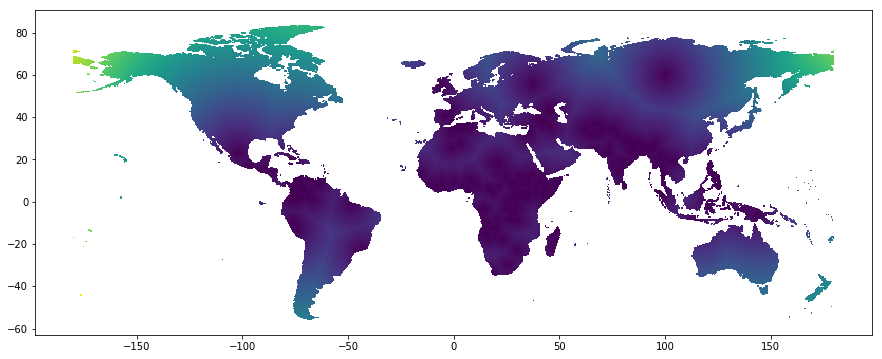

In [192]:
pickle_test_gdf[pickle_test_gdf['year']==2002].plot(column = 'nearest_conflict', figsize=(15, 15))
plt.show()

----

----

# SIMD RESTEN OVER I EN NY NOTEBOOK!!!

----

# DET ER HER DU SKAL SPLITTE!!!
---

**Men behøver du faktisk det? kan du ikke bare bruge den 'best' data du har fra efter 2010** Ja, men det er først i en alle sidste konkluderende test!
Det er jo to lidt forskellige ting. I det ene tilfælde ser du om din model også kan finde y ud fra nye x'er. I det andet tilfælde hvad din model kan ude i fremtiden. Husk dit y er allerede lead'ed, sǻ du kikker allerede et år ud med det setop du har nu.

In [30]:
def ratio(df=df):
    
    '''Displaying the ratio between test and train'''
    
    total_cell_count = df.shape[0]
    test_split_count = df[df['year'] > 2005].shape[0]
    train_splti_count = df[df['year'] <= 2005].shape[0]

    test_ratio = test_split_count/total_cell_count
    train_ratio = train_splti_count/total_cell_count

    print('Split so tresting is years after 2005: test data {:.2}%, train data {:.2}%\n'.format(test_ratio,train_ratio))

    
def n_events(df=df, set_name = 'train_set'):

    '''Displaying the count of events and non events'''
    
    
    events = df[df['best'] > 0]['best'].count()
    non_events = df[df['best'] == 0]['best'].count()
    prob = (events/(non_events+events))*100

    print('Number of events in {}: {}'.format(set_name, events))
    print('Number of non-events in {}: {}'.format(set_name, non_events))
    print('Percent of obs that are events: {:.3}%\n'.format(prob))
    
    
def split(df=df):
    
    '''Split the dataset and print some sanity check info'''
    
    ratio()
    
    test_df = df[df['year'] > 2005].copy()
    train_df = df[df['year'] <= 2005].copy()
    
    print('train data from {} to {}'.format(train_df['year'].min(),train_df['year'].max()))
    print('test data from {} to {}\n'.format(test_df['year'].min(),test_df['year'].max()))

    n_events(df, 'full_set')
    n_events(train_df, 'train_set')
    n_events(test_df, 'test_set')
    
    print('*events understood as cell-years with one or more fatalities as definded be the feature "best".')
    
    return(train_df, test_df)

train_df, test_df = split()

Split so tresting is years after 2005: test data 0.24%, train data 0.76%

train data from 1990 to 2005
test data from 2006 to 2010

Number of events in full_set: 15871
Number of non-events in full_set: 1345295
Percent of obs that are events: 1.17%

Number of events in train_set: 11651
Number of non-events in train_set: 1025425
Percent of obs that are events: 1.12%

Number of events in test_set: 4220
Number of non-events in test_set: 319870
Percent of obs that are events: 1.3%

*events understood as cell-years with one or more fatalities as definded be the feature "best".


# Look at the data:

### the dif between a balanced and unbalanced set:

In [31]:
df_s = train_df.sample(10000, random_state=123)
    
n_events(df_s, 'train_sampel')

Number of events in train_sampel: 85
Number of non-events in train_sampel: 9915
Percent of obs that are events: 0.85%



Men du burde lave min 3 random samples for robusthed...

In [32]:
def balanced_sample():

    all_events = df[df['best']>0].copy()
    non_events_sample = df[df['best']==0].sample(all_events.shape[0], random_state=123).copy() #men burde du ikke gøre det ihh. til lead_binary_best?
    frames = [all_events, non_events_sample]
    df_balanced_sample = pd.concat(frames)

    n_events(df_balanced_sample, 'balanced_train_sample')
    
    return(df_balanced_sample)

df_bs = balanced_sample()

Number of events in balanced_train_sample: 15871
Number of non-events in balanced_train_sample: 15871
Percent of obs that are events: 50.0%



### GO on:

### Histograms

make readable agin..

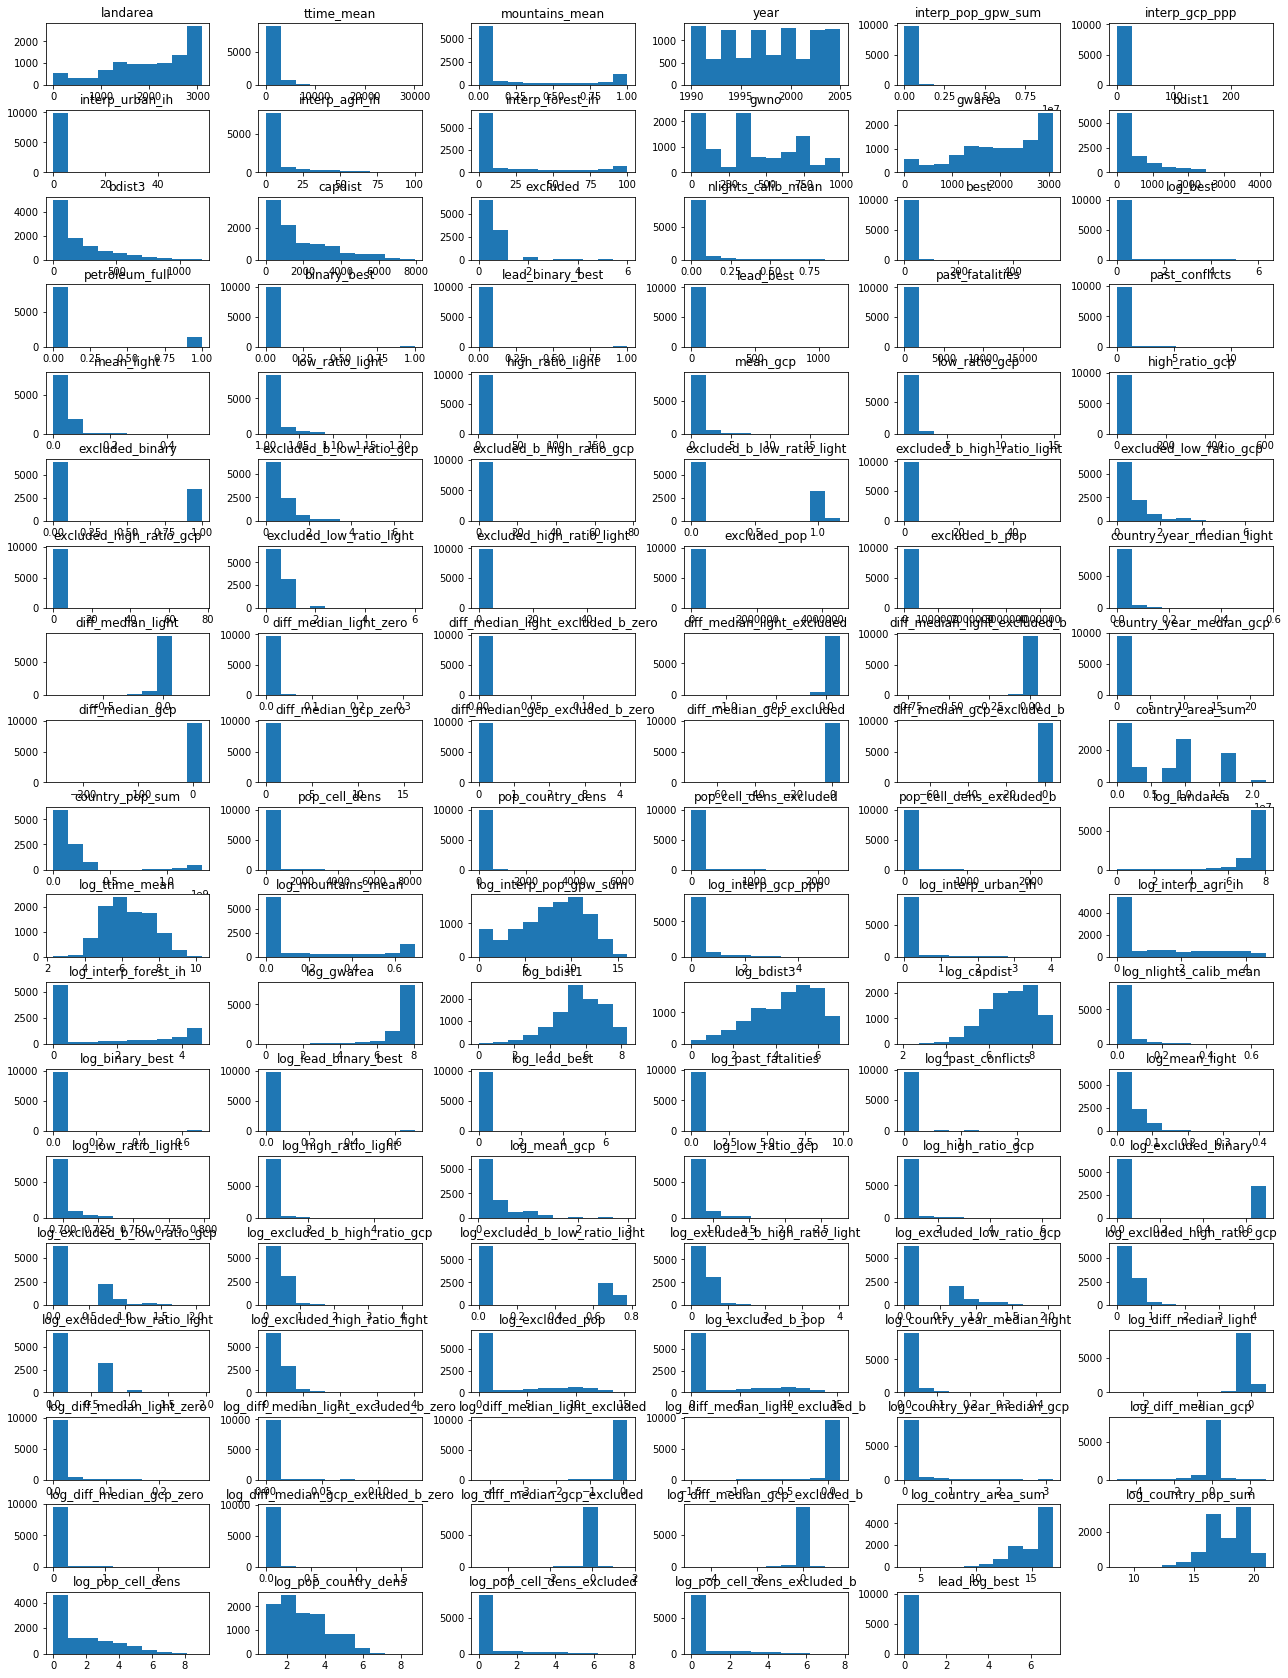

In [33]:
def mass_hist(df=df):
    
    features = df.columns[2:]
    
    nfeatures = len(features)
    cols=6 
    rows=math.ceil(nfeatures/cols)
    
    fig = plt.figure(figsize = (22,30))
    fig.subplots_adjust(hspace = 0.4, wspace = 0.3)
        
    for i in np.arange(nfeatures):
        plot_n = i+1
        plt.subplot(rows,cols,plot_n)
        plt.hist(x=df[features[i]].dropna())
        plt.title(features[i])
                
    plt.show()

mass_hist(df=df_s)

### Scatters:
**Uses the balanced set so pontential relationsships are not too prepressed by the rarety of events**

For exploration I plot all features against first 'lead_best', then 'log_lead_best' and lastly 'binary_lead_best' wich is the taget I will use for the logit model (so potential in zero-component in a zero inflated negative binominel...)



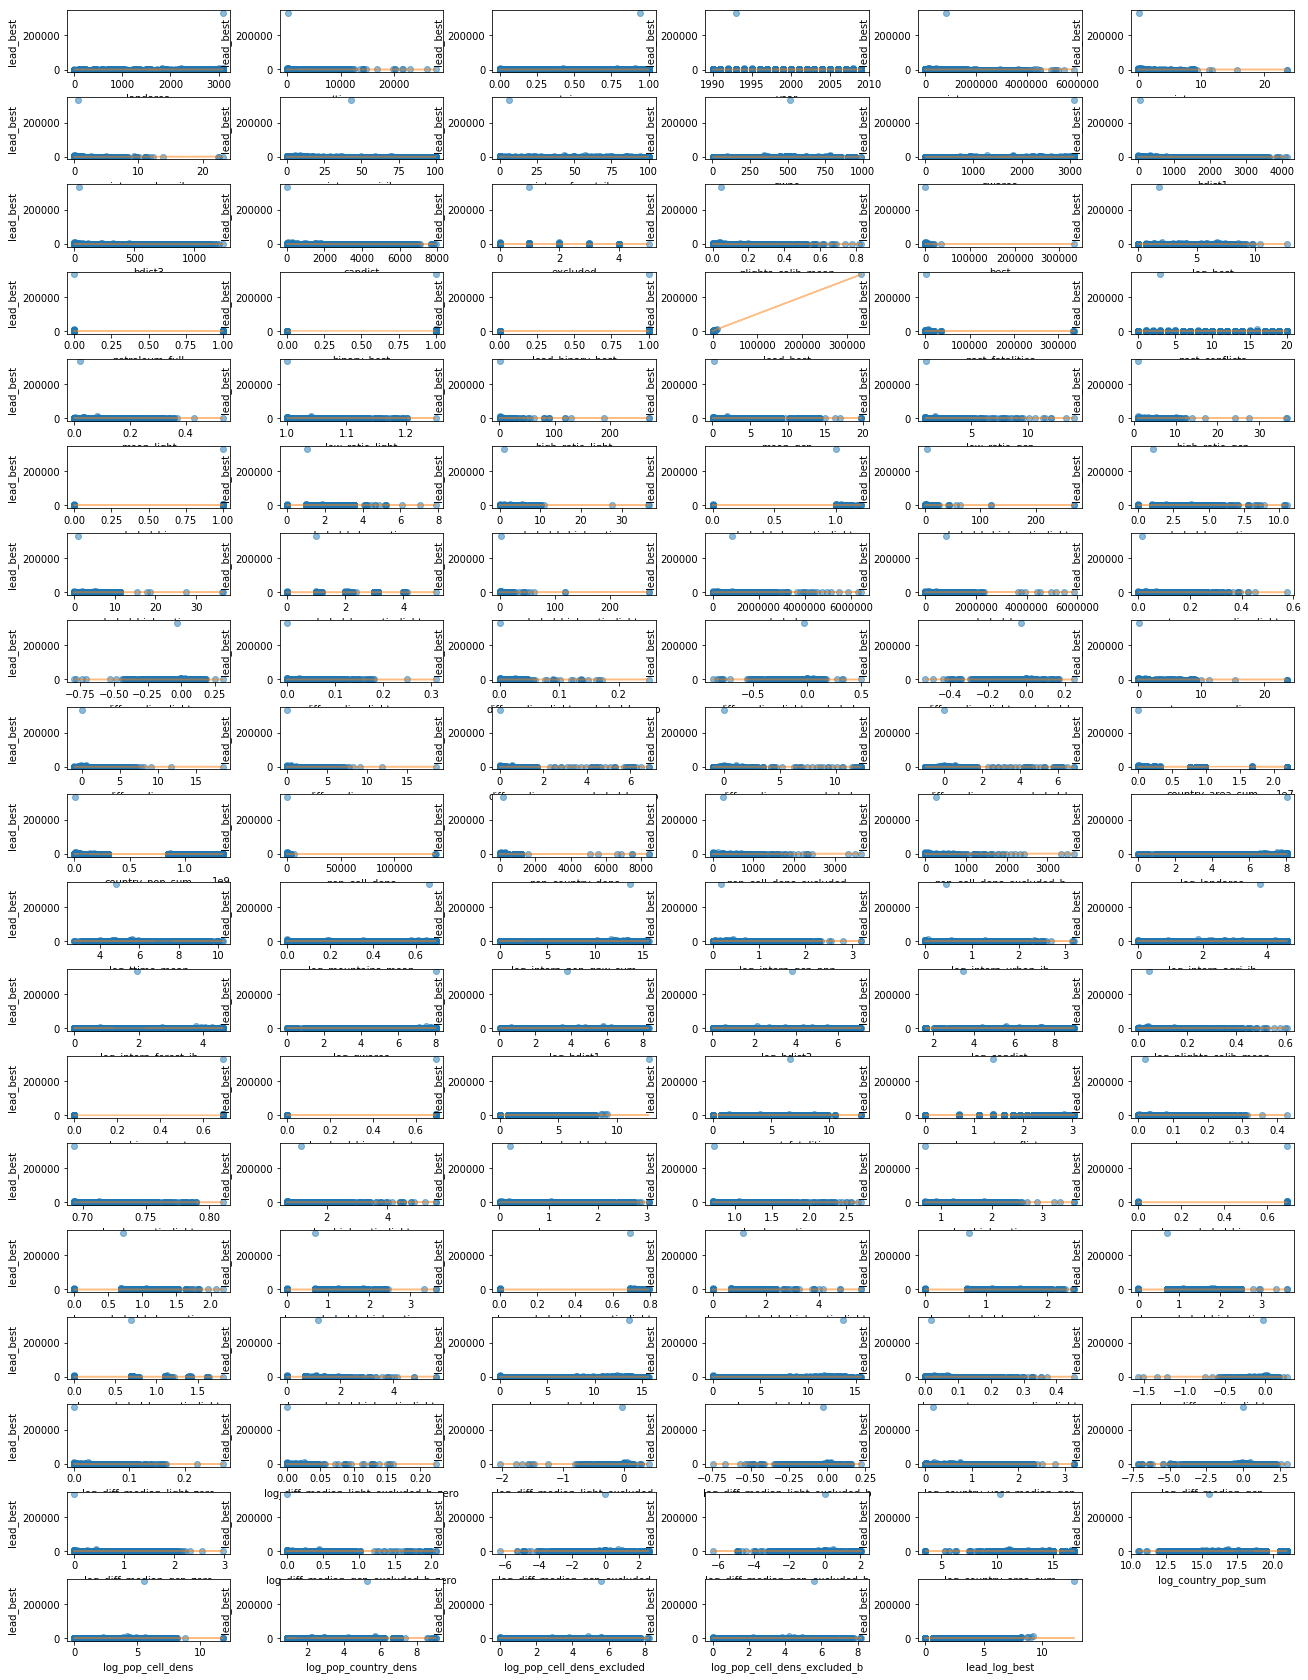

In [34]:
def mass_scatter(df=df):
    
    features = df.columns[2:]

    nfeatures = len(features)
    cols=6 
    rows=math.ceil(nfeatures/cols)
    
    fig = plt.figure(figsize = (22,30))
    fig.subplots_adjust(hspace = 0.4, wspace = 0.3)
        
    for i in np.arange(nfeatures):
        plot_n = i+1

        plt.subplot(rows,cols,plot_n)
        
        # ------------------ :
        #plt.scatter(data=df[[features[i],'best']].dropna(), x=features[i], y='best',alpha = 0.5)
        
        data = df.dropna()

        xi = data[features[i]]
        y = data['lead_best']

        slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
        line = slope*xi+intercept
        plt.plot(xi,y,'o', xi, line, alpha = 0.5)
        
        # ---------------------
        plt.xlabel(features[i])
        plt.ylabel('lead_best')
        
    plt.show()

mass_scatter(df=df_bs)

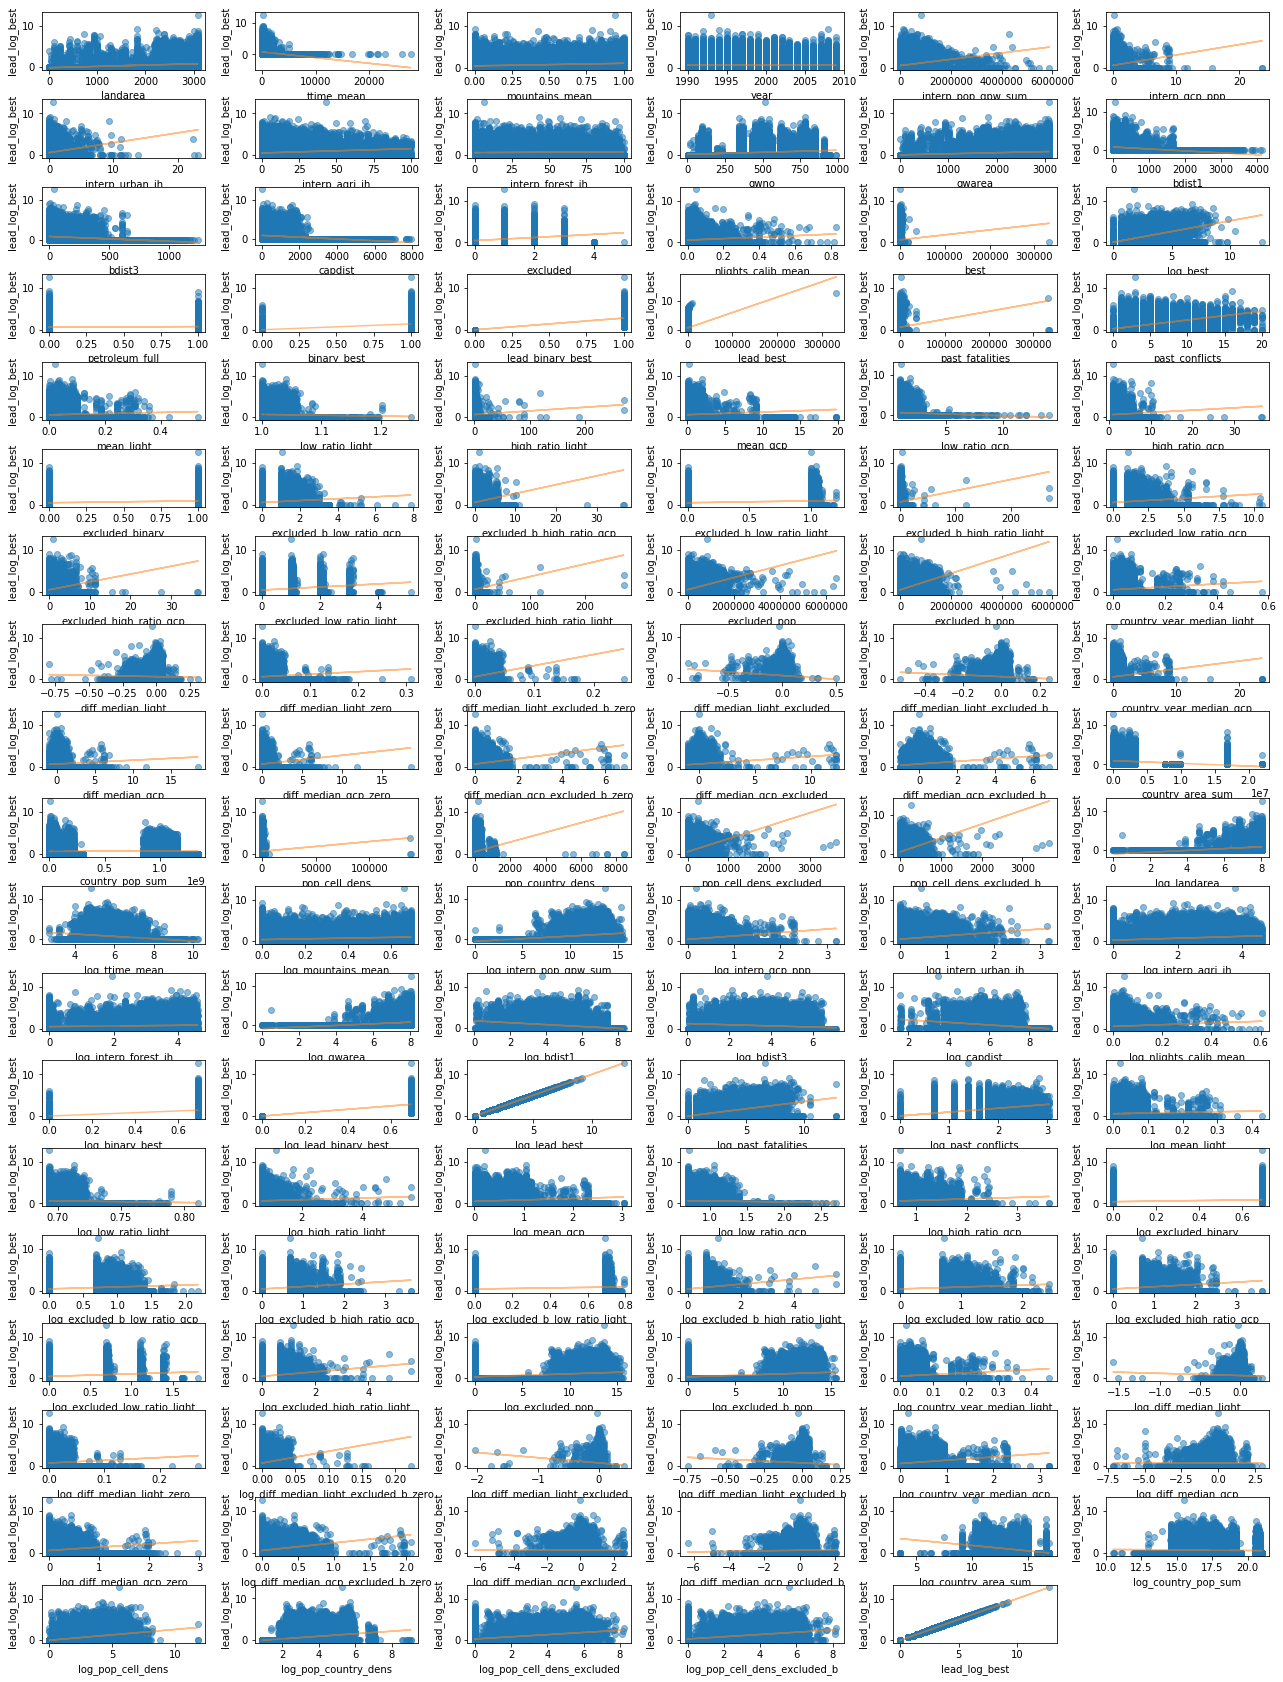

In [35]:
def mass_scatter_ylog(df=df_s):
    
    features = df.columns[2:]

    nfeatures = len(features)
    cols=6 
    rows=math.ceil(nfeatures/cols)
    
    fig = plt.figure(figsize = (22,30))
    fig.subplots_adjust(hspace = 0.5, wspace = 0.3)
        
    for i in np.arange(nfeatures):
        plot_n = i+1

        plt.subplot(rows,cols,plot_n)
        # ------------------------------
        #plt.scatter(data=df[[features[i],'log_best']].dropna(), x=features[i], y='log_best',alpha = 0.5)
        
        data = df.dropna()

        xi = data[features[i]]
        y = data['lead_log_best']

        slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
        line = slope*xi+intercept
        plt.plot(xi,y,'o', xi, line, alpha = 0.5)
        
        # ---------------------
        
        plt.xlabel(features[i])
        plt.ylabel('lead_log_best')
        
    plt.show()

mass_scatter_ylog(df=df_bs)

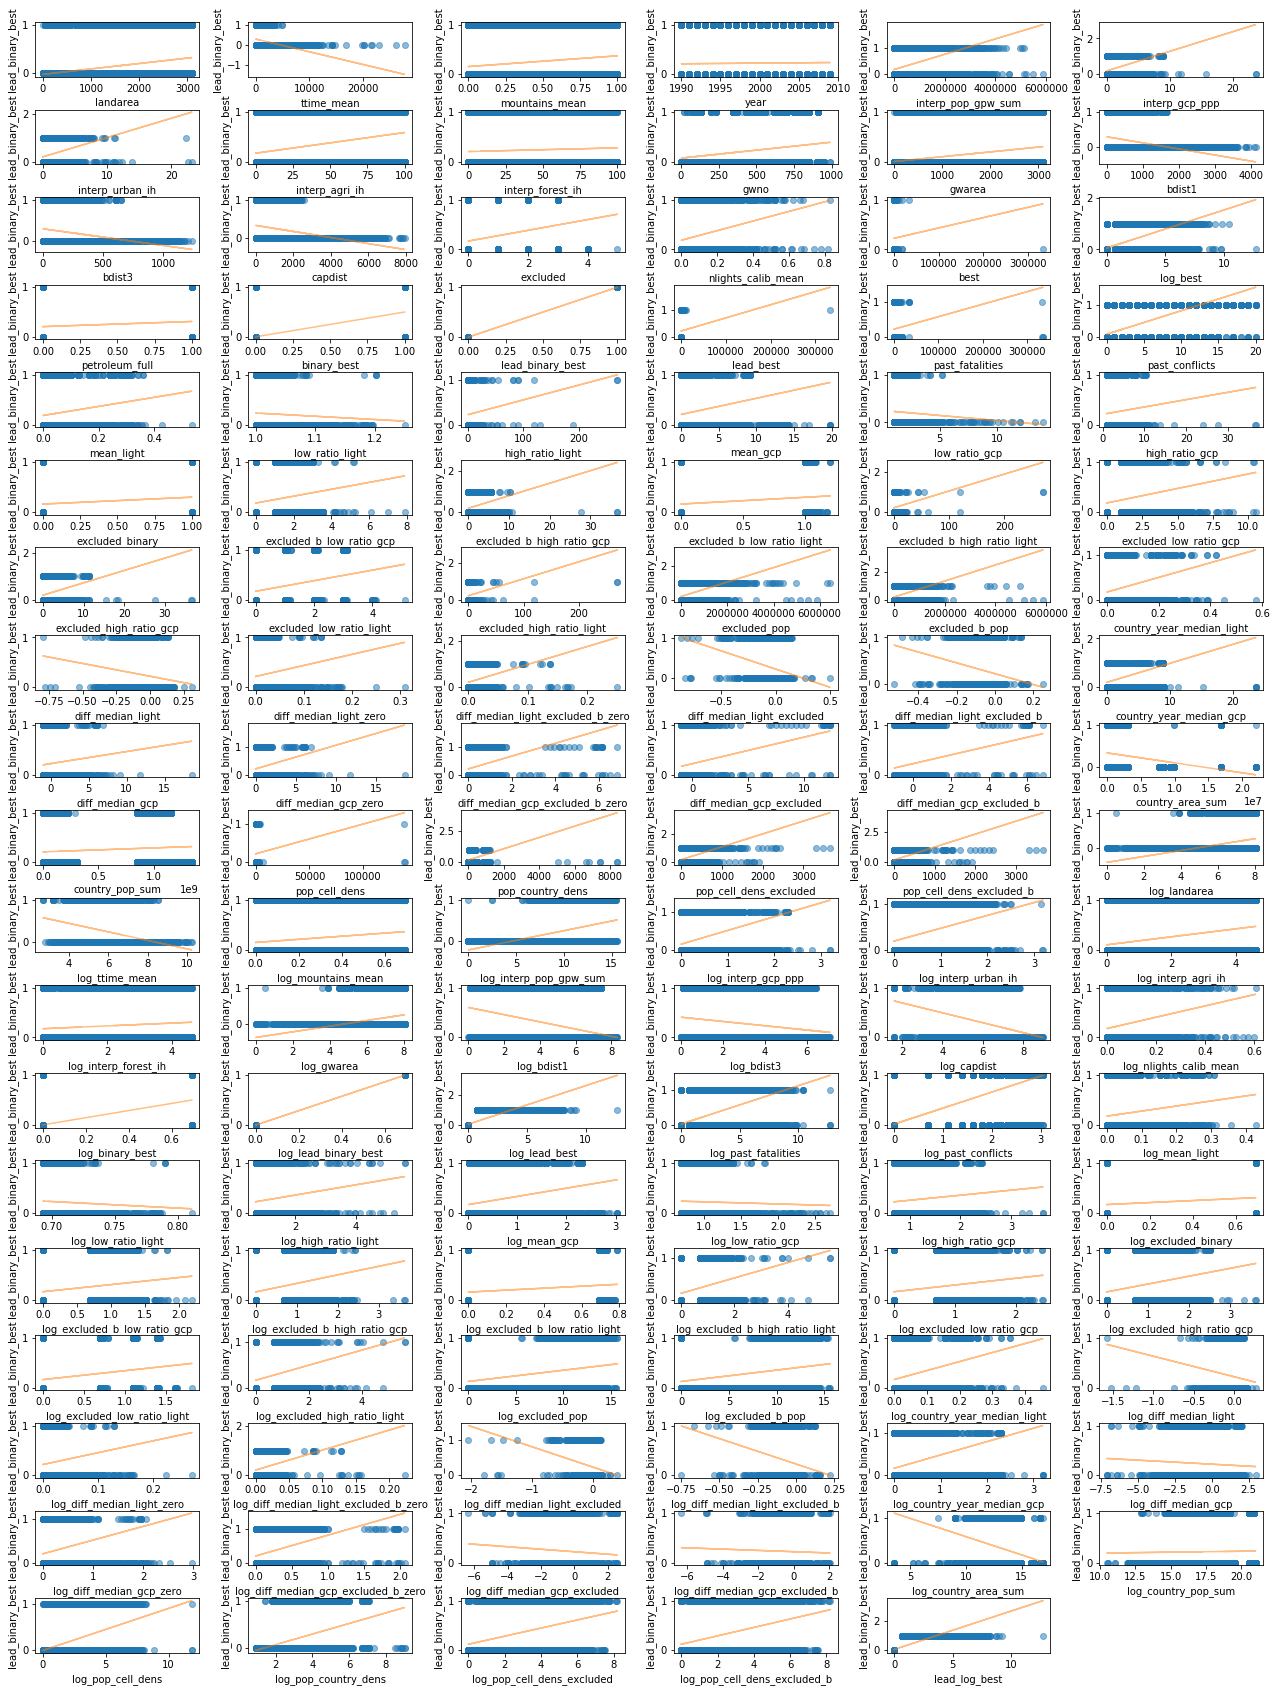

In [36]:
def mass_scatter_ybinary(df=df_s):
    
    features = df.columns[2:]

    nfeatures = len(features)
    cols=6 
    rows=math.ceil(nfeatures/cols)
    
    fig = plt.figure(figsize = (22,30))
    fig.subplots_adjust(hspace = 0.6, wspace = 0.3)
        
    for i in np.arange(nfeatures):
        plot_n = i+1

        plt.subplot(rows,cols,plot_n)
        
        # ----------------------------
        #plt.scatter(data=df[[features[i],'binary_best']].dropna(), y=features[i], x='binary_best',alpha = 0.5)
        
                
        data = df.dropna()

        xi = data[features[i]]
        y = data['lead_binary_best']

        slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
        line = slope*xi+intercept
        plt.plot(xi,y,'o', xi, line, alpha = 0.5)
        
        # ---------------------
        
        
        plt.xlabel(features[i])
        plt.ylabel('lead_binary_best')
        
    plt.show()

mass_scatter_ybinary(df=df_bs)

### VIGITIGT!
**Du mangler stadigt at gøre gwno, gid og year katagoriske og lave distance matrixen. Men dt kan måske vent til selve model konstruktionen.**
Det er ikke noget der skal plottes, men det kan lige så godt blive gjort. Om end du gemmer de i deres egne dataframes.

# Map-check
Sanity check:

In [37]:
# # 2002
# for i in df.iloc[:,2:].columns:
#     if df[str(i)].dtype != type(object):
#         df[df['year']==2002].plot(column = str(i), figsize=(15, 15))
#         plt.title(str(i))
#         plt.show()

# Feature Selection


- Uses train_df and df_bs
- Demeaning, men giver det mening i random forest? Ja for du gider ikke tage alle de katagoriske var med.
- Kunne du brige random forest og feature importance her? Giv det et skud.
- Skulle du dele op i ongoing/not allerede her?
- Skulle du lave forward feature selection på subset af features; dem er er konstrueret ud fra samme basis feature.

# Random forest feature imprtance (entropy)

## Classification:

In [147]:
from sklearn.ensemble import RandomForestClassifier

features_to_drop = ['geometry','best', 'log_best', 'binary_best', 'lead_binary_best', 'lead_best','log_binary_best', 'log_lead_binary_best', 'log_lead_best','lead_log_best']


def fit_forest_class(features_to_drop = features_to_drop):
    
    forest = RandomForestClassifier(n_estimators=250,random_state=0,criterion='entropy',n_jobs=-1)
    
    data_train_full = train_df.dropna().copy()

    X = data_train_full.drop(features_to_drop, axis = 1)
        
    y = np.array(data_train_full['lead_binary_best'])

    forest.fit(X, y)
    
    return(forest, X, y)

def importanceplot(forest = forest, X=X, xlabel = 'entropy'):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=[15,int(X.shape[1]/3)])
    plt.title("Feature importances")
    plt.barh(range(X.shape[1]), importances[indices],
       color="salmon", yerr=std[indices], align="center")

    plt.yticks(range(X.shape[1]),  X.columns[indices])
    plt.ylim([-1, X.shape[1]])

    plt.xlabel(xlabel)
    plt.ylabel('features')

    sns.despine()
    plt.show()

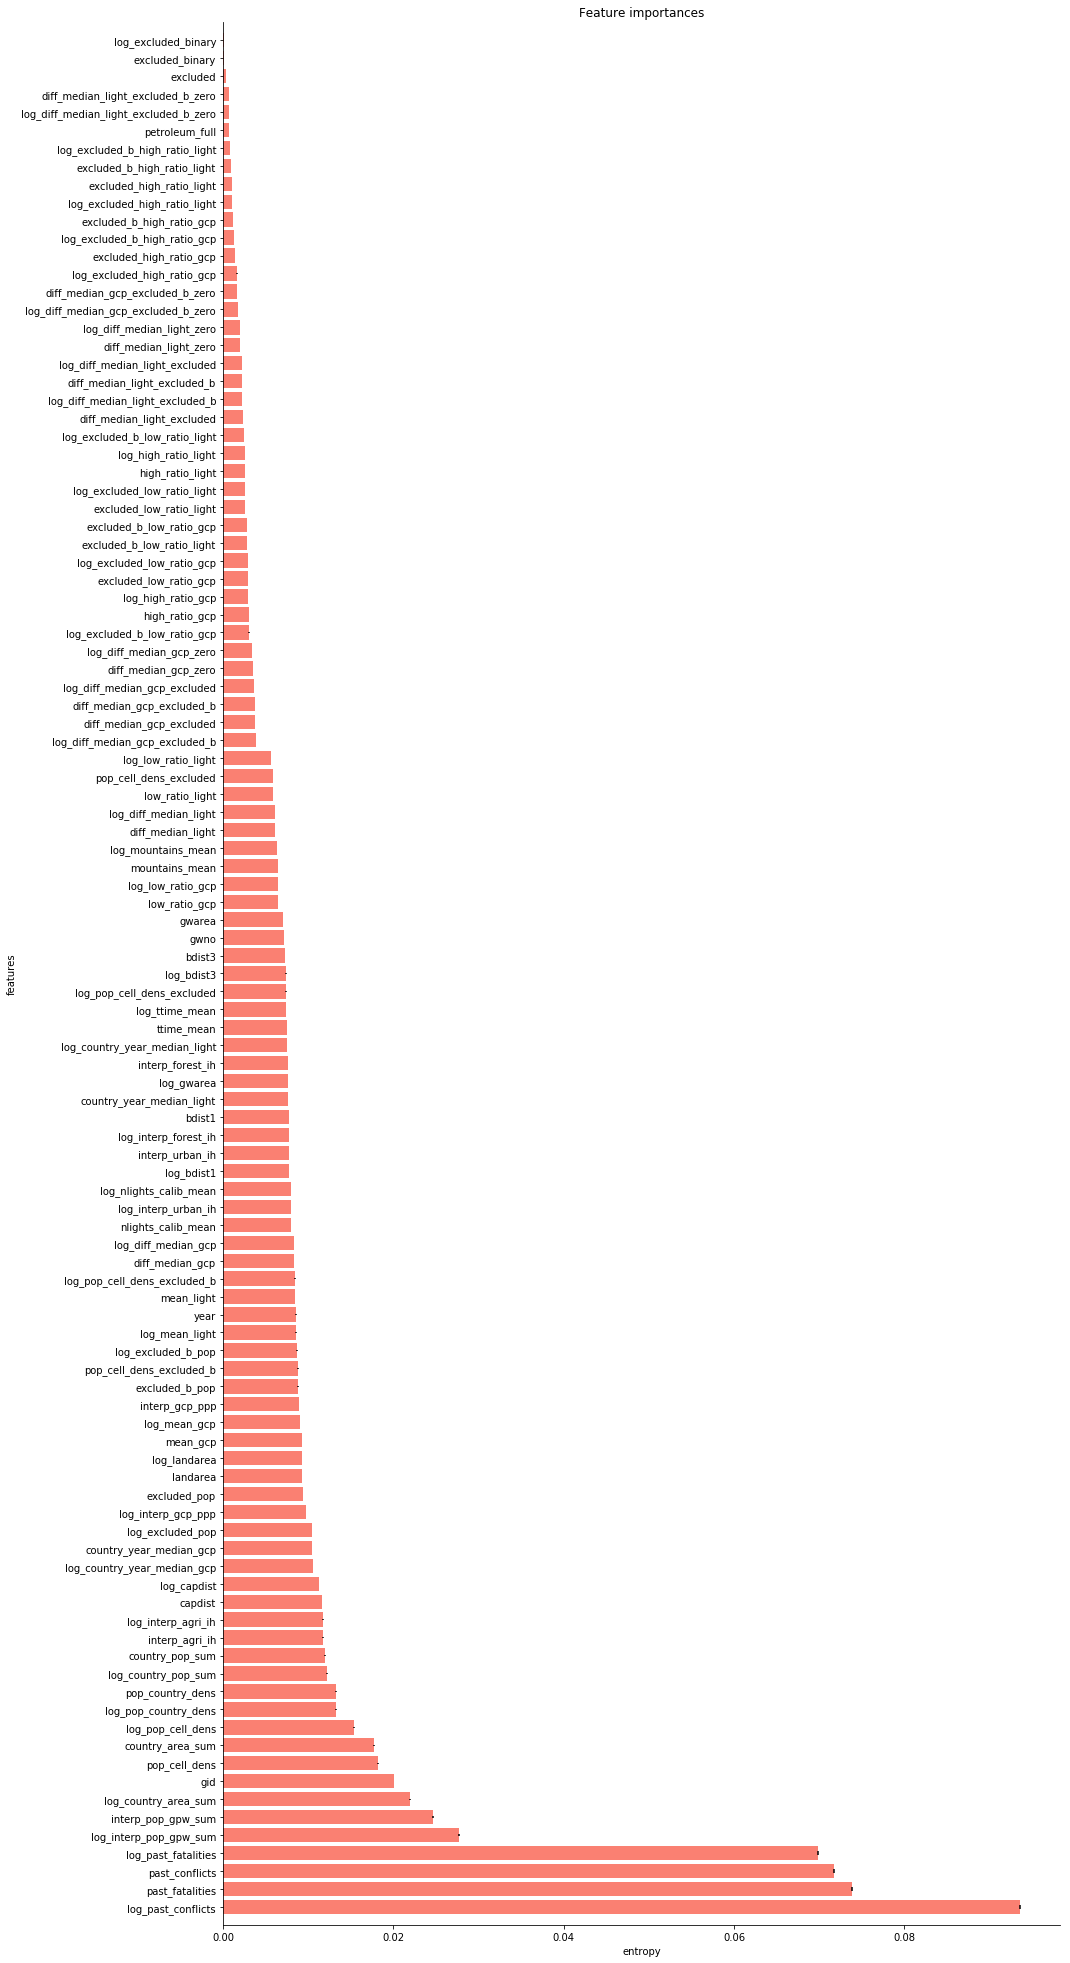

In [148]:
forest,X,y = fit_forest_class(features_to_drop)
importanceplot(forest, X, 'entropy')

## Regression:

In [153]:
from sklearn.ensemble import RandomForestRegressor

features_to_drop = ['geometry','best', 'log_best', 'binary_best', 'lead_binary_best', 'lead_best','log_binary_best', 'log_lead_binary_best', 'log_lead_best','lead_log_best']


def fit_forest_reg(features_to_drop = features_to_drop):
    
    forest = RandomForestRegressor(n_estimators=250,random_state=0,criterion='mse',n_jobs=-1)

    data_train_full = train_df.dropna().copy()

    X = data_train_full.drop(features_to_drop, axis = 1)
        
    y = np.array(data_train_full['lead_best'])

    forest.fit(X, y)
    
    return(forest, X, y)

# def importanceplot(forest = forest, X=X):
#     importances = forest.feature_importances_
#     std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
#     indices = np.argsort(importances)[::-1]
    
#     plt.figure(figsize=[15,int(X.shape[1]/3)])
#     plt.title("Feature importances")
#     plt.barh(range(X.shape[1]), importances[indices],
#        color="salmon", yerr=std[indices], align="center")

#     plt.yticks(range(X.shape[1]),  X.columns[indices])
#     plt.ylim([-1, X.shape[1]])

#     plt.xlabel('entropy')
#     plt.ylabel('features')

#     sns.despine()
#     plt.show()

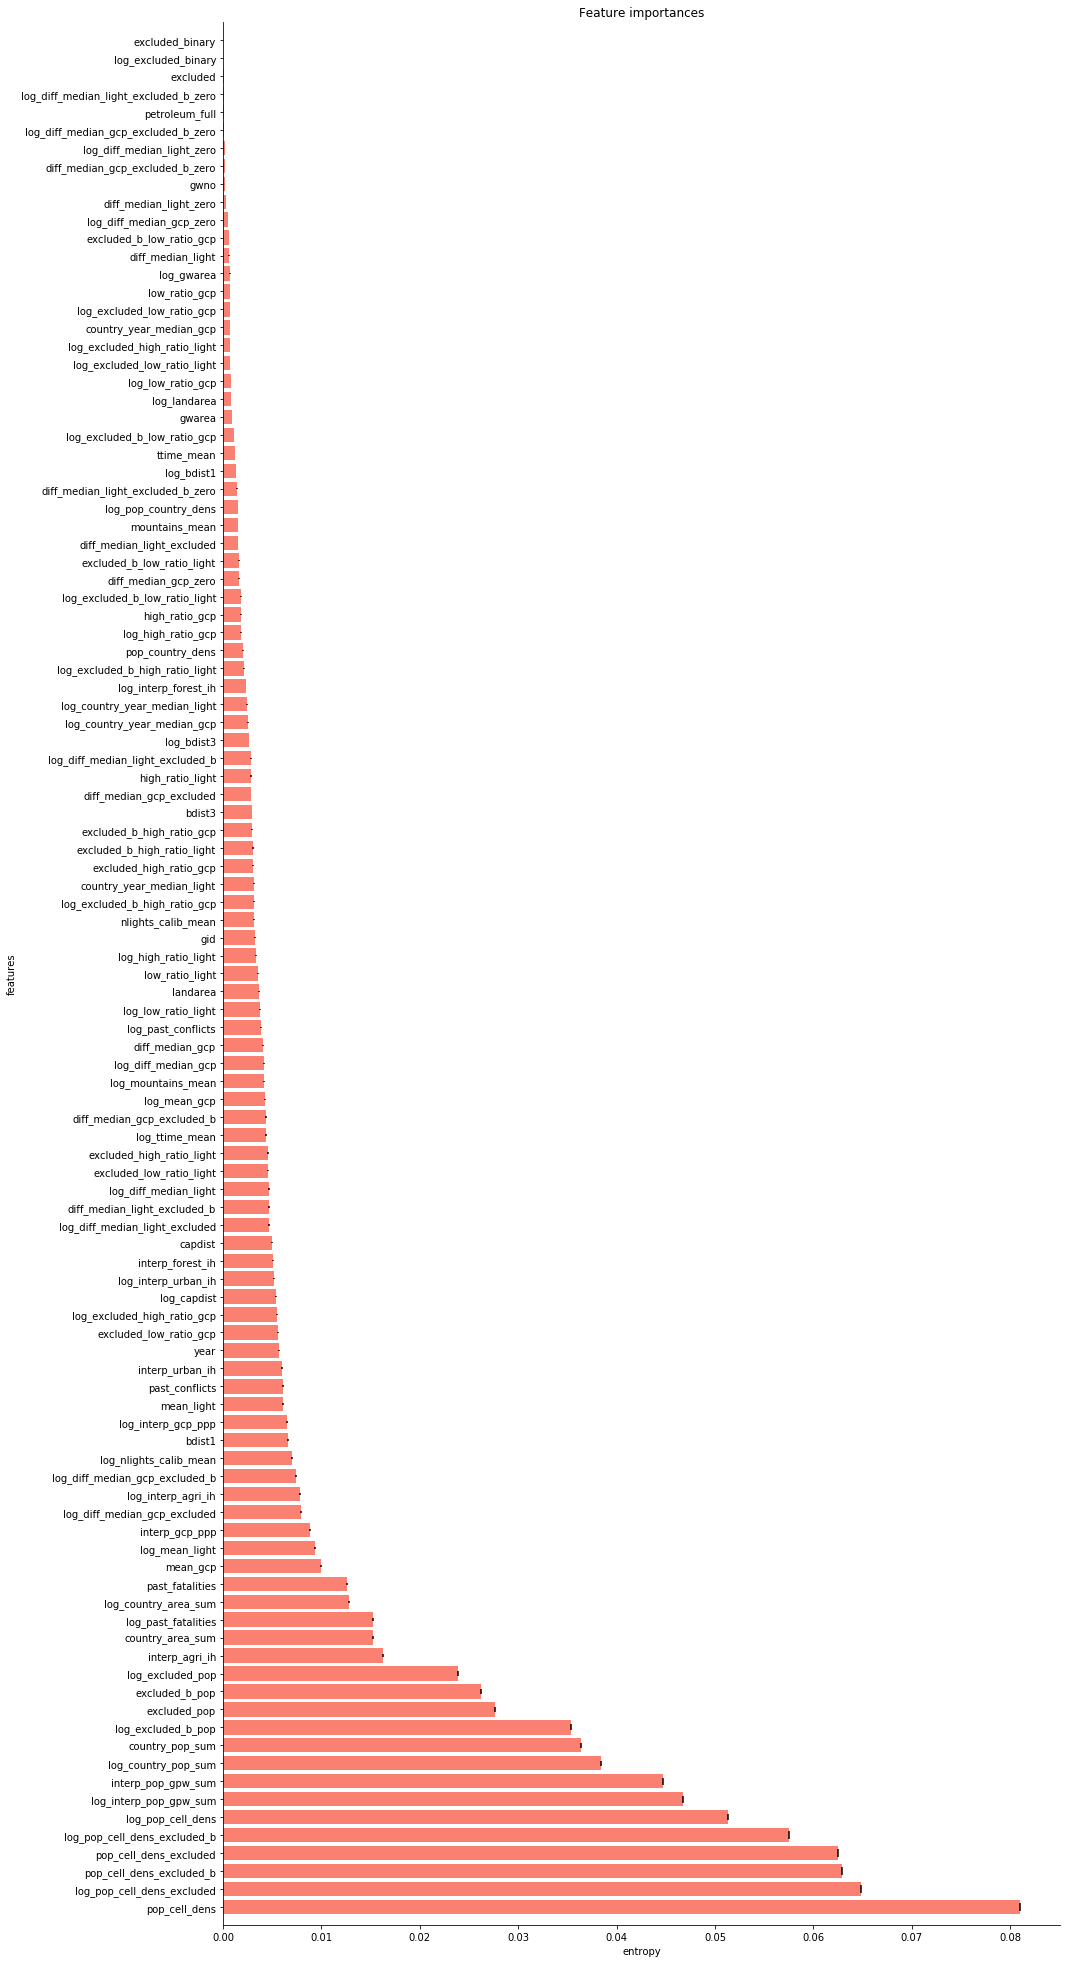

In [154]:
forest,X,y = fit_forest_reg(features_to_drop)
importanceplot(forest, X, 'mse')

## DER ER IKKE NOGET DER FOR HINDRE DIG I DEMEANING I FS DELEN!

In [38]:
df.columns

Index(['gid', 'geometry', 'landarea', 'ttime_mean', 'mountains_mean', 'year',
       'interp_pop_gpw_sum', 'interp_gcp_ppp', 'interp_urban_ih',
       'interp_agri_ih',
       ...
       'log_diff_median_gcp_excluded_b_zero', 'log_diff_median_gcp_excluded',
       'log_diff_median_gcp_excluded_b', 'log_country_area_sum',
       'log_country_pop_sum', 'log_pop_cell_dens', 'log_pop_country_dens',
       'log_pop_cell_dens_excluded', 'log_pop_cell_dens_excluded_b',
       'lead_log_best'],
      dtype='object', length=115)

Så du bliver nød til at sortere lidt (hårdt) ud her....

----
# Her er du kommet til:

Med så mange features har du du nogle få mugligheder...

Du kan se om nogle af dem kan reduceres via PCA...
Du kan selv vælge nogle fra givet din viden og data undersøgelse. Eks variabler der ser bedre ud efter log transformation..
Du kan sætte et maks over features du vil havde i din model... Lidt en farlig vej...
Du kan køre sequantial feature selection... Det gør dog din undersøgelse mindre teoritisk robust...

Du kan ikke - uden at gøre noget drastisk først/sætte maks over features køre Exhaustive Feature selection -

- Du kan self sætte et maks og se om den over hovedt kommer der op....


I stedet for at includere variablerne skulle du bare havde en liste over variabler du ikke vill includere...

In [39]:
df.columns

Index(['gid', 'geometry', 'landarea', 'ttime_mean', 'mountains_mean', 'year',
       'interp_pop_gpw_sum', 'interp_gcp_ppp', 'interp_urban_ih',
       'interp_agri_ih',
       ...
       'log_diff_median_gcp_excluded_b_zero', 'log_diff_median_gcp_excluded',
       'log_diff_median_gcp_excluded_b', 'log_country_area_sum',
       'log_country_pop_sum', 'log_pop_cell_dens', 'log_pop_country_dens',
       'log_pop_cell_dens_excluded', 'log_pop_cell_dens_excluded_b',
       'lead_log_best'],
      dtype='object', length=115)

In [40]:
# #Calculate number of models to run:

# from mlxtend.feature_selection import SequentialFeatureSelector as sfs
# from mlxtend.feature_selection import ExhaustiveFeatureSelector as efs
# from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# from sklearn import linear_model
# from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, classification_report, precision_score, recall_score


# data_train_full = train_df.dropna().copy()
# data_train_bs = df_bs.dropna().copy() # balanced


# # You don't included gid, gwno and year here. They are part of the heirarchi and might clutter the result. Alternativly run both with and without.. Nope that would be weird them being a load af catagorical variables...
# # Each of these x's need to be justified in your doc..

# # From 0.13 it works with a pandas dataframe..

# # men der er vel et problem med past conflict da du her også tæller nyeste conflicter med. De skal ud før du smaler det..
# # Du skal tænke dig godt om vedr. hvilke variabler du ville have IRL.

# # det handler om  'binary_best', 'best','log_best' 'past_fatalities', 'past_conflicts', 'log_past_fatalities', 'log_past_conflicts'. Skal nok læse op på the conflict trap...
# # Men det burde dit hierarchi vel også fange? TIl AT STARTE MED OM IKKE ANDET...

# # LAV NEGATIV LISTE I STEDET!!! Eller bare drop dine konflict var..

# feature_list = ['landarea', 'ttime_mean', 'mountains_mean',
#        'interp_pop_gpw_sum', 'interp_gcp_ppp', 'interp_urban_ih',
#        'interp_agri_ih', 'interp_forest_ih', 'gwarea', 'bdist1',
#        'bdist3', 'capdist', 'excluded', 'nlights_calib_mean',
#        'log_best', 'petroleum_full',
#        'mean_light',
#        'low_ratio_light', 'high_ratio_light', 'mean_gcp','log_mean_gcp', 'low_ratio_gcp',
#        'high_ratio_gcp', 'excluded_binary', 'excluded_b_low_ratio_gcp',
#        'excluded_b_high_ratio_gcp', 'excluded_b_low_ratio_light',
#        'excluded_b_high_ratio_light', 'excluded_low_ratio_gcp',
#        'excluded_high_ratio_gcp', 'excluded_low_ratio_light',
#        'excluded_high_ratio_light', 'excluded_pop', 'excluded_b_pop',
#        'country_year_median_light', 'diff_median_light',
#        'diff_median_light_excluded', 'diff_median_light_excluded_b',
#        'country_year_median_gcp', 'diff_median_gcp',
#        'diff_median_gcp_excluded', 'diff_median_gcp_excluded_b',
#        'diff_median_light_excluded_b_zero', 'diff_median_gcp_excluded_b_zero',
#        'log_landarea', 'log_ttime_mean', 'log_mountains_mean',
#        'log_interp_pop_gpw_sum', 'log_interp_gcp_ppp', 'log_interp_urban_ih',
#        'log_interp_agri_ih', 'log_interp_forest_ih', 'log_gwarea',
#        'log_bdist1', 'log_bdist3', 'log_capdist',
#        'log_nlights_calib_mean', 'log_excluded_pop', 'log_excluded_b_pop', 'log_low_ratio_light',
#        'log_high_ratio_light', 'log_low_ratio_gcp', 'log_high_ratio_gcp',
#        'log_diff_median_light_excluded_b_zero',
#        'log_diff_median_gcp_excluded_b_zero','country_area_sum','country_pop_sum','log_country_area_sum','log_country_pop_sum']

# X_full = data_train_full[feature_list]
# X_bs = data_train_bs[feature_list]

# y_full = np.array(data_train_full['lead_binary_best'])
# y_bs = np.array(data_train_bs['lead_binary_best'])


In [41]:
train_df.columns

Index(['gid', 'geometry', 'landarea', 'ttime_mean', 'mountains_mean', 'year',
       'interp_pop_gpw_sum', 'interp_gcp_ppp', 'interp_urban_ih',
       'interp_agri_ih',
       ...
       'log_diff_median_gcp_excluded_b_zero', 'log_diff_median_gcp_excluded',
       'log_diff_median_gcp_excluded_b', 'log_country_area_sum',
       'log_country_pop_sum', 'log_pop_cell_dens', 'log_pop_country_dens',
       'log_pop_cell_dens_excluded', 'log_pop_cell_dens_excluded_b',
       'lead_log_best'],
      dtype='object', length=115)

In [42]:

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.feature_selection import ExhaustiveFeatureSelector as efs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn import linear_model
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, classification_report, precision_score, recall_score

import math

features_to_drop = ['gid','geometry','year','gwno','binary_best', 
                    'lead_binary_best','lead_best', 'past_fatalities', 
                    'past_conflicts','log_past_fatalities', 'log_past_conflicts',
                   'lead_log_best', 'log_lead_binary_best', 'log_lead_best','log_best','best',
                    'diff_median_light','diff_median_light_excluded', 'log_diff_median_light_zero',
                    'diff_median_light_excluded_b','diff_median_gcp', 'diff_median_gcp_zero', 
                    'diff_median_gcp_excluded','diff_median_gcp_excluded_b', 'log_diff_median_gcp_zero',
                    'log_binary_best','log_diff_median_light','log_diff_median_light_excluded',
                    'log_diff_median_light_excluded_b','log_diff_median_gcp','log_diff_median_gcp_excluded',
                    'log_diff_median_gcp_excluded_b','log_diff_median_light_excluded_b_zero', 
                    'log_diff_median_gcp_excluded_b_zero', 'diff_median_gcp_excluded_b_zero',
                    'log_excluded_b_low_ratio_gcp','log_excluded_b_high_ratio_gcp', 
                    'log_excluded_b_low_ratio_light','log_excluded_b_high_ratio_light',
                    'log_excluded_low_ratio_gcp','log_excluded_high_ratio_gcp', 
                    'log_excluded_low_ratio_light','log_excluded_high_ratio_light', 
                    'excluded_b_high_ratio_gcp','excluded_b_high_ratio_light', 'log_diff_median_light_zero',
                    'excluded_high_ratio_gcp','excluded_high_ratio_light' , 'excluded_pop',
                    'log_excluded_pop','log_excluded_b_pop','high_ratio_light','high_ratio_gcp',
                    'log_high_ratio_light','log_high_ratio_gcp','log_excluded_binary','log_pop_cell_dens',
                    'log_pop_country_dens','log_pop_cell_dens_excluded','log_pop_cell_dens_excluded_b',
                    'interp_gcp_ppp','mean_gcp','low_ratio_gcp','excluded_b_low_ratio_gcp',
                    'excluded_low_ratio_gcp','excluded_low_ratio_light','country_year_median_gcp',
                    'log_interp_gcp_ppp','log_mean_gcp','log_low_ratio_gcp','log_country_year_median_gcp',
                    'excluded', 'pop_cell_dens_excluded', 'log_landarea', 'log_gwarea','log_mountains_mean']


data_train_full = train_df.dropna().copy()
data_train_bs = df_bs.dropna().copy() # balanced

X_full = data_train_full.drop(features_to_drop, axis = 1)
X_bs = data_train_bs.drop(features_to_drop, axis = 1)

# X_full = data_train_full[feature_list]
# X_bs = data_train_bs[feature_list]

y_full = np.array(data_train_full['lead_binary_best'])
y_bs = np.array(data_train_bs['lead_binary_best'])

In [43]:
# for ExhaustiveFeatureSelector

def count_ex_f(X=X_full, set_name = 'full train set'):
    M = X.shape[1] 
    N = 2**M
    print("Number of models to run with exhaustive feature selection for {}: {}\n".format(set_name,N))
    
def count_ex_f_capped(X=X_full, max_feature_n = 5 , set_name = 'full train set'):
    r = max_feature_n
    n = X.shape[1]
    
    N = math.factorial(n)/(math.factorial(r)*math.factorial(n-r))
    
    #print(N)

    print("Max number of models to run with exhaustive feature selection for {} with max {} features: {}\n".format(set_name,int(r),int(N)))

    
# For Sequential feature selection
def count_seq_f(X=X_full, set_name = 'full train set'):
    M = X.shape[1]
    N = ((M*(M+1))/2)+1
    print("Max number of models to run with sequential feature selection for {}: {}\n".format(set_name,int(N)))
    
    
    
count_ex_f(X_full)
count_ex_f_capped()
count_seq_f(X_full)


count_ex_f(X_bs, 'ballanced train set')
count_seq_f(X_bs, 'ballanced train set')
count_ex_f_capped(X_bs, 5, set_name = 'ballanced train set')

# minutes it takes to run one logit regrssion


def time_test(x=X_full, y = y_full, set_name = 'full train set'):
    time_start = time.time()

    clf = linear_model.LogisticRegression().fit(x,y)


    time_stop = time.time()
    time_to_finish = time_stop - time_start
    print('minutes it took to run a logit regression on {}: {}\n' .format(set_name,str(time_to_finish/60)))

    
time_test(X_full)
time_test(X_bs , y_bs, 'ballanced train set')



Number of models to run with exhaustive feature selection for full train set: 1099511627776

Max number of models to run with exhaustive feature selection for full train set with max 5 features: 658008

Max number of models to run with sequential feature selection for full train set: 821

Number of models to run with exhaustive feature selection for ballanced train set: 1099511627776

Max number of models to run with sequential feature selection for ballanced train set: 821

Max number of models to run with exhaustive feature selection for ballanced train set with max 5 features: 658008

minutes it took to run a logit regression on full train set: 0.5814825177192688

minutes it took to run a logit regression on ballanced train set: 0.01000370979309082



# FS
Du burde bruge under-sampling og f1...
Du skal havde konflict mål med (men hvilke?)
år og gid-> kan du ikke fordi den så tager en af gangen... Så skal der være in option til det.. Det tror jeg faktisk der er..
Country pop?

In a review of the quantitative literature on civil war, Sambanis
(2002) identified the following three core variables that are almost always included
in models of civil war onset: the natural log of population (Inpop), the length of
peacetime until the outbreak of a war (pt8, which we model as a decay function of
time at peace), and the natural log of per capita gross domestic product (GDP) in
constant dollars (Ingdp).

In [44]:
for i in X_bs.columns:
    print(i)

print('Features: {}'. format(len(X_bs.columns)))

landarea
ttime_mean
mountains_mean
interp_pop_gpw_sum
interp_urban_ih
interp_agri_ih
interp_forest_ih
gwarea
bdist1
bdist3
capdist
nlights_calib_mean
petroleum_full
mean_light
low_ratio_light
excluded_binary
excluded_b_low_ratio_light
excluded_b_pop
country_year_median_light
diff_median_light_zero
diff_median_light_excluded_b_zero
country_area_sum
country_pop_sum
pop_cell_dens
pop_country_dens
pop_cell_dens_excluded_b
log_ttime_mean
log_interp_pop_gpw_sum
log_interp_urban_ih
log_interp_agri_ih
log_interp_forest_ih
log_bdist1
log_bdist3
log_capdist
log_nlights_calib_mean
log_mean_light
log_low_ratio_light
log_country_year_median_light
log_country_area_sum
log_country_pop_sum
Features: 40


# Ballanced set:

### AUC ROC

In [45]:
# AUC_ROC:

time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 10, forward = True, verbose = 1, scoring = 'roc_auc', cv = 5, n_jobs = 6)

sfs_f = sfs_f.fit(X_bs,y_bs)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))

bs_auc_metric_dict = sfs_f.get_metric_dict()
bs_auc_metric = sfs_f.get_metric_dict()

#sfs_f.subsets_

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    7.4s finished
Features: 1/10[Parallel(n_jobs=6)]: Done  39 out of  39 | elapsed:    6.1s finished
Features: 2/10[Parallel(n_jobs=6)]: Done  38 out of  38 | elapsed:    7.0s finished
Features: 3/10[Parallel(n_jobs=6)]: Done  37 out of  37 | elapsed:   13.3s finished
Features: 4/10[Parallel(n_jobs=6)]: Done  36 out of  36 | elapsed:   13.1s finished
Features: 5/10[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:   16.6s finished
Features: 6/10[Parallel(n_jobs=6)]: Done  34 out of  34 | elapsed:   17.5s finished
Features: 7/10[Parallel(n_jobs=6)]: Done  33 out of  33 | elapsed:   17.9s finished
Features: 8/10[Parallel(n_jobs=6)]: Done  32 out of  32 | elapsed:   19.9s finished
Features: 9/10[Parallel(n_jobs=6)]: Done  31 out of  31 | elapsed:   19.7s finished
Features: 10/10


minutes it took: 2.3960447033246357



In [46]:
# Choose function:
# lidt uelegant at den ligger her, men pyt..

def first_best(selector = sfs_f):

    result = 0

    for i in np.arange(1,len(selector.k_feature_idx_)+1):

        if selector.get_metric_dict()[i]['avg_score'] > result:

            result = selector.get_metric_dict()[i]['avg_score']
            feature_index = selector.get_metric_dict()[i]['feature_idx']
            feature_names = selector.get_metric_dict()[i]['feature_names']
            n_features = len(feature_index)

        else:
            break
     
    return([n_features,result,feature_index,feature_names])

In [47]:
bs_auc = first_best(selector = sfs_f)

In [48]:
bs_auc

[5,
 0.8418480698938033,
 (7, 12, 16, 27, 31),
 ('gwarea',
  'petroleum_full',
  'excluded_b_low_ratio_light',
  'log_interp_pop_gpw_sum',
  'log_bdist1')]

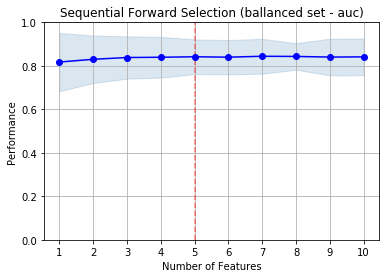

In [49]:

plot_sfs(bs_auc_metric, kind='std_dev')
plt.ylim([0, 1])

plt.vlines(bs_auc[0], 0, 1, 'red', 'dashed', alpha = 0.5)

plt.title('Sequential Forward Selection (ballanced set - auc)')
plt.grid()
plt.show()

### Recall

In [50]:
# recall:

time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 10, forward = True, verbose = 1, scoring = 'recall', cv = 5, n_jobs = 6)

sfs_f = sfs_f.fit(X_bs,y_bs)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))

#bs_recall = first_best()
bs_recall_metric = sfs_f.get_metric_dict()


#sfs_f.subsets_

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    7.1s finished
Features: 1/10[Parallel(n_jobs=6)]: Done  39 out of  39 | elapsed:    6.2s finished
Features: 2/10[Parallel(n_jobs=6)]: Done  38 out of  38 | elapsed:    6.9s finished
Features: 3/10[Parallel(n_jobs=6)]: Done  37 out of  37 | elapsed:   13.1s finished
Features: 4/10[Parallel(n_jobs=6)]: Done  36 out of  36 | elapsed:   18.0s finished
Features: 5/10[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:   18.9s finished
Features: 6/10[Parallel(n_jobs=6)]: Done  34 out of  34 | elapsed:   20.1s finished
Features: 7/10[Parallel(n_jobs=6)]: Done  33 out of  33 | elapsed:   36.9s finished
Features: 8/10[Parallel(n_jobs=6)]: Done  32 out of  32 | elapsed:   36.3s finished
Features: 9/10[Parallel(n_jobs=6)]: Done  31 out of  31 | elapsed:   36.1s finished
Features: 10/10


minutes it took: 3.414162349700928



In [51]:
bs_recall = first_best(selector = sfs_f)

In [52]:
bs_recall

[8,
 0.37019259559914564,
 (4, 9, 11, 16, 23, 27, 33, 38),
 ('interp_urban_ih',
  'bdist3',
  'nlights_calib_mean',
  'excluded_b_low_ratio_light',
  'pop_cell_dens',
  'log_interp_pop_gpw_sum',
  'log_capdist',
  'log_country_area_sum')]

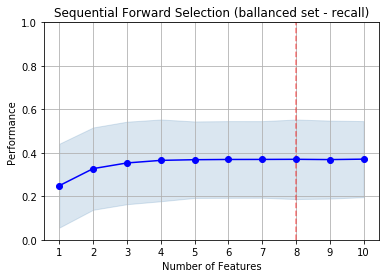

In [53]:
plot_sfs(bs_recall_metric, kind='std_dev')
plt.ylim([0, 1])

plt.vlines(bs_recall[0], 0, 1, 'red', 'dashed', alpha = 0.5)

plt.title('Sequential Forward Selection (ballanced set - recall)')
plt.grid()
plt.show()

### Acc

In [54]:
# acc:

time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 10, forward = True, verbose = 1, scoring = 'accuracy', cv = 5, n_jobs = 6)

sfs_f = sfs_f.fit(X_bs,y_bs)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))

#bs_acc = first_best()
bs_acc_metric = sfs_f.get_metric_dict()

#sfs_f.subsets_

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    6.9s finished
Features: 1/10[Parallel(n_jobs=6)]: Done  39 out of  39 | elapsed:    4.8s finished
Features: 2/10[Parallel(n_jobs=6)]: Done  38 out of  38 | elapsed:    5.2s finished
Features: 3/10[Parallel(n_jobs=6)]: Done  37 out of  37 | elapsed:   11.1s finished
Features: 4/10[Parallel(n_jobs=6)]: Done  36 out of  36 | elapsed:   11.3s finished
Features: 5/10[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:   16.2s finished
Features: 6/10[Parallel(n_jobs=6)]: Done  34 out of  34 | elapsed:   15.9s finished
Features: 7/10[Parallel(n_jobs=6)]: Done  33 out of  33 | elapsed:   16.1s finished
Features: 8/10[Parallel(n_jobs=6)]: Done  32 out of  32 | elapsed:   16.3s finished
Features: 9/10[Parallel(n_jobs=6)]: Done  31 out of  31 | elapsed:   16.8s finished
Features: 10/10


minutes it took: 2.099281895160675



In [55]:
bs_acc = first_best(selector = sfs_f)

In [56]:
bs_acc

[10,
 0.7931977137325146,
 (2, 8, 12, 14, 16, 18, 19, 25, 31, 34),
 ('mountains_mean',
  'bdist1',
  'petroleum_full',
  'low_ratio_light',
  'excluded_b_low_ratio_light',
  'country_year_median_light',
  'diff_median_light_zero',
  'pop_cell_dens_excluded_b',
  'log_bdist1',
  'log_nlights_calib_mean')]

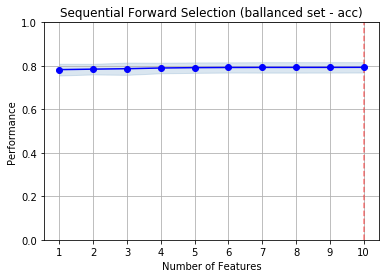

In [57]:
plot_sfs(bs_acc_metric, kind='std_dev')
plt.ylim([0, 1])

plt.vlines(bs_acc[0], 0, 1, 'red', 'dashed', alpha = 0.5)

plt.title('Sequential Forward Selection (ballanced set - acc)')
plt.grid()
plt.show()

### Kan du få precision of f1 til at spille med anden cv? 

#### Average Precision (or precision/recall curve)

In [58]:
# precision:

time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 10, forward = True, verbose = 1, scoring = 'average_precision', cv = 5, n_jobs = 6)

sfs_f = sfs_f.fit(X_bs,y_bs)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))

#bs_acc = first_best()
bs_ap_metric = sfs_f.get_metric_dict()

#sfs_f.subsets_

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    7.3s finished
Features: 1/10[Parallel(n_jobs=6)]: Done  39 out of  39 | elapsed:    5.9s finished
Features: 2/10[Parallel(n_jobs=6)]: Done  38 out of  38 | elapsed:    6.7s finished
Features: 3/10[Parallel(n_jobs=6)]: Done  37 out of  37 | elapsed:   14.4s finished
Features: 4/10[Parallel(n_jobs=6)]: Done  36 out of  36 | elapsed:   18.7s finished
Features: 5/10[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:   21.9s finished
Features: 6/10[Parallel(n_jobs=6)]: Done  34 out of  34 | elapsed:   30.0s finished
Features: 7/10[Parallel(n_jobs=6)]: Done  33 out of  33 | elapsed:   33.1s finished
Features: 8/10[Parallel(n_jobs=6)]: Done  32 out of  32 | elapsed:   34.0s finished
Features: 9/10[Parallel(n_jobs=6)]: Done  31 out of  31 | elapsed:   32.3s finished
Features: 10/10


minutes it took: 3.492803390820821



In [59]:
bs_ap = first_best(selector = sfs_f)

In [60]:
bs_ap

[7,
 0.5996845916387743,
 (4, 9, 16, 23, 25, 26, 27),
 ('interp_urban_ih',
  'bdist3',
  'excluded_b_low_ratio_light',
  'pop_cell_dens',
  'pop_cell_dens_excluded_b',
  'log_ttime_mean',
  'log_interp_pop_gpw_sum')]

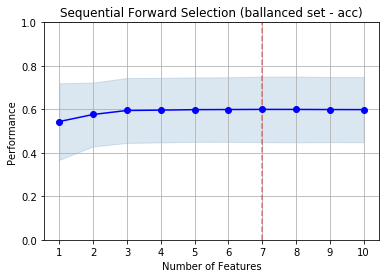

In [61]:
plot_sfs(bs_ap_metric, kind='std_dev')
plt.ylim([0, 1])

plt.vlines(bs_ap[0], 0, 1, 'red', 'dashed', alpha = 0.5)

plt.title('Sequential Forward Selection (ballanced set - acc)')
plt.grid()
plt.show()

#### Pricision micro - but what are your theoritical reason? -> gives the same as acc...
" Micro-averaged metrics should be used when the size of datasets are variable. "  https://medium.com/@ramit.singh.pahwa/micro-macro-precision-recall-and-f-score-44439de1a044
Så det giver ikke megen mening her. Men på den anden side; det virker?


In [62]:
# # precision:

# time_start = time.time()

# sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 10, forward = True, verbose = 1, scoring = 'precision_micro', cv = 5, n_jobs = 6)

# sfs_f = sfs_f.fit(X_bs,y_bs)


# time_stop = time.time()
# time_to_finish = time_stop - time_start

# print('\nminutes it took: {}\n'. format(time_to_finish/60))

# #bs_acc = first_best()
# bs_pmic_metric = sfs_f.get_metric_dict()

# #sfs_f.subsets_

In [63]:
# bs_pmic = first_best(selector = sfs_f)

In [64]:
# bs_pmic

In [65]:
# plot_sfs(bs_pmic_metric, kind='std_dev')
# plt.ylim([0, 1])

# plt.vlines(bs_pmic[0], 0, 1, 'red', 'dashed', alpha = 0.5)

# plt.title('Sequential Forward Selection (ballanced set - acc)')
# plt.grid()
# plt.show()

# full (imbalanced) data 

### AUC ROC

In [66]:
time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 10, forward = True, verbose = 1, scoring = 'roc_auc', cv = 5, n_jobs = 6)

sfs_f = sfs_f.fit(X_full,y_full)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))

#full_auc = first_best()
full_auc_metric = sfs_f.get_metric_dict()

#sfs_f.subsets_

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:  4.0min finished
Features: 1/10[Parallel(n_jobs=6)]: Done  39 out of  39 | elapsed:  8.5min finished
Features: 2/10[Parallel(n_jobs=6)]: Done  38 out of  38 | elapsed: 10.5min finished
Features: 3/10[Parallel(n_jobs=6)]: Done  37 out of  37 | elapsed: 10.7min finished
Features: 4/10[Parallel(n_jobs=6)]: Done  36 out of  36 | elapsed: 11.0min finished
Features: 5/10[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed: 10.8min finished
Features: 6/10[Parallel(n_jobs=6)]: Done  34 out of  34 | elapsed: 10.9min finished
Features: 7/10[Parallel(n_jobs=6)]: Done  33 out of  33 | elapsed: 11.1min finished
Features: 8/10[Parallel(n_jobs=6)]: Done  32 out of  32 | elapsed: 11.6min finished
Features: 9/10[Parallel(n_jobs=6)]: Done  31 out of  31 | elapsed: 11.5min finished
Features: 10/10


minutes it took: 100.69983720382055



In [67]:
full_auc = first_best(selector = sfs_f)

In [68]:
full_auc

[5,
 0.87492337065067,
 (3, 13, 17, 19, 20),
 ('interp_pop_gpw_sum',
  'mean_light',
  'excluded_b_pop',
  'diff_median_light_zero',
  'diff_median_light_excluded_b_zero')]

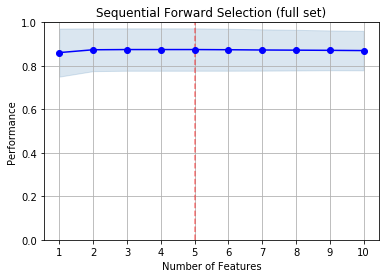

In [69]:
plot_sfs(full_auc_metric, kind='std_dev') # 
plt.ylim([0, 1])

plt.vlines(full_auc[0], 0, 1, 'red', 'dashed', alpha = 0.5)

plt.title('Sequential Forward Selection (full set)')
plt.grid()
plt.show()

### Recall

In [70]:
time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 10, forward = True, verbose = 1, scoring = 'recall', cv = 5, n_jobs = 6)

sfs_f = sfs_f.fit(X_full,y_full)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))

full_recall = first_best()
full_recall_metric = sfs_f.get_metric_dict()

#sfs_f.subsets_

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:  4.0min finished
Features: 1/10[Parallel(n_jobs=6)]: Done  39 out of  39 | elapsed:  7.6min finished
Features: 2/10[Parallel(n_jobs=6)]: Done  38 out of  38 | elapsed:  6.8min finished
Features: 3/10[Parallel(n_jobs=6)]: Done  37 out of  37 | elapsed:  9.4min finished
Features: 4/10[Parallel(n_jobs=6)]: Done  36 out of  36 | elapsed: 12.1min finished
Features: 5/10[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed: 13.2min finished
Features: 6/10[Parallel(n_jobs=6)]: Done  34 out of  34 | elapsed: 13.2min finished
Features: 7/10[Parallel(n_jobs=6)]: Done  33 out of  33 | elapsed: 21.8min finished
Features: 8/10[Parallel(n_jobs=6)]: Done  32 out of  32 | elapsed: 23.0min finished
Features: 9/10[Parallel(n_jobs=6)]: Done  31 out of  31 | elapsed: 22.8min finished
Features: 10/10


minutes it took: 134.18339762687683



In [71]:
full_recall = first_best(selector = sfs_f)

In [72]:
full_recall

[8,
 0.020949840770133288,
 (3, 5, 10, 17, 18, 23, 30, 33),
 ('interp_pop_gpw_sum',
  'interp_agri_ih',
  'capdist',
  'excluded_b_pop',
  'country_year_median_light',
  'pop_cell_dens',
  'log_interp_forest_ih',
  'log_capdist')]

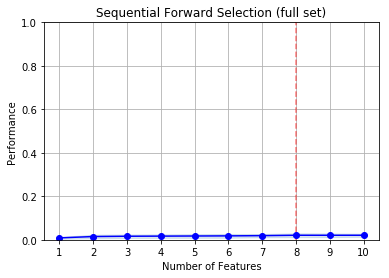

In [73]:
plot_sfs(full_recall_metric, kind='std_dev')
plt.ylim([0, 1])

plt.vlines(full_recall[0], 0, 1, 'red', 'dashed', alpha = 0.5)

plt.title('Sequential Forward Selection (full set)')
plt.grid()
plt.show()

#### Average Precision (resion recall curve):



In [74]:
# Average precision:

time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 10, forward = True, verbose = 1, scoring = 'average_precision', cv = 5, n_jobs = 6)

sfs_f = sfs_f.fit(X_full,y_full)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))

#bs_acc = first_best()
full_ap_metric = sfs_f.get_metric_dict()

#sfs_f.subsets_

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:  4.0min finished
Features: 1/10[Parallel(n_jobs=6)]: Done  39 out of  39 | elapsed:  5.9min finished
Features: 2/10[Parallel(n_jobs=6)]: Done  38 out of  38 | elapsed:  6.0min finished
Features: 3/10[Parallel(n_jobs=6)]: Done  37 out of  37 | elapsed:  6.0min finished
Features: 4/10[Parallel(n_jobs=6)]: Done  36 out of  36 | elapsed: 11.0min finished
Features: 5/10[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed: 11.3min finished
Features: 6/10[Parallel(n_jobs=6)]: Done  34 out of  34 | elapsed: 12.1min finished
Features: 7/10[Parallel(n_jobs=6)]: Done  33 out of  33 | elapsed: 12.4min finished
Features: 8/10[Parallel(n_jobs=6)]: Done  32 out of  32 | elapsed: 12.7min finished
Features: 9/10[Parallel(n_jobs=6)]: Done  31 out of  31 | elapsed: 13.1min finished
Features: 10/10


minutes it took: 94.47156394322714



In [75]:
full_ap = first_best(selector = sfs_f)

In [76]:
full_ap

[2, 0.6217990115433366, (0, 19), ('landarea', 'diff_median_light_zero')]

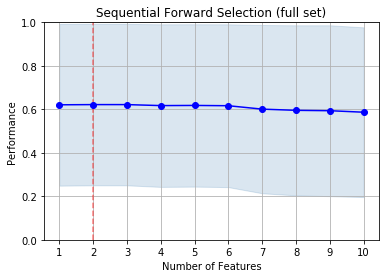

In [77]:
plot_sfs(full_ap_metric, kind='std_dev')
plt.ylim([0, 1])

plt.vlines(full_ap[0], 0, 1, 'red', 'dashed', alpha = 0.5)

plt.title('Sequential Forward Selection (full set)')
plt.grid()
plt.show()

# Time total:

In [78]:
full_script_time_stop = time.time()

full_script_time_final = full_script_time_stop - full_script_time

print('Minutes the script took to run: {}'. format(full_script_time_final/60))

Minutes the script took to run: 347.0052649219831


# Så som det ser ud her har du så 33 var der skal køre exhuastive på; igen både full og bs og alle metric

In [79]:
bs_recall[3]

('interp_urban_ih',
 'bdist3',
 'nlights_calib_mean',
 'excluded_b_low_ratio_light',
 'pop_cell_dens',
 'log_interp_pop_gpw_sum',
 'log_capdist',
 'log_country_area_sum')

In [80]:
bs_acc[3]

('mountains_mean',
 'bdist1',
 'petroleum_full',
 'low_ratio_light',
 'excluded_b_low_ratio_light',
 'country_year_median_light',
 'diff_median_light_zero',
 'pop_cell_dens_excluded_b',
 'log_bdist1',
 'log_nlights_calib_mean')

In [81]:
bs_auc[3]

('gwarea',
 'petroleum_full',
 'excluded_b_low_ratio_light',
 'log_interp_pop_gpw_sum',
 'log_bdist1')

In [82]:
#bs_pmic[3] # hvis den skal med?? Helt den samme som acc?

In [92]:
bs_ap[3]

('interp_urban_ih',
 'bdist3',
 'excluded_b_low_ratio_light',
 'pop_cell_dens',
 'pop_cell_dens_excluded_b',
 'log_ttime_mean',
 'log_interp_pop_gpw_sum')

In [83]:
full_auc[3]

('interp_pop_gpw_sum',
 'mean_light',
 'excluded_b_pop',
 'diff_median_light_zero',
 'diff_median_light_excluded_b_zero')

In [84]:
full_recall[3]

('interp_pop_gpw_sum',
 'interp_agri_ih',
 'capdist',
 'excluded_b_pop',
 'country_year_median_light',
 'pop_cell_dens',
 'log_interp_forest_ih',
 'log_capdist')

In [85]:
full_ap[3]

('landarea', 'diff_median_light_zero')

In [93]:
from collections import Counter

selected_fetures_list = full_ap[3] + full_recall[3] + full_auc[3] + bs_auc[3] + bs_acc[3] + bs_recall[3] + bs_ap[3]# + bs_pmic[3]    

c_selected = Counter(selected_fetures_list)

In [94]:
c_selected

Counter({'bdist1': 1,
         'bdist3': 2,
         'capdist': 1,
         'country_year_median_light': 2,
         'diff_median_light_excluded_b_zero': 1,
         'diff_median_light_zero': 3,
         'excluded_b_low_ratio_light': 4,
         'excluded_b_pop': 2,
         'gwarea': 1,
         'interp_agri_ih': 1,
         'interp_pop_gpw_sum': 2,
         'interp_urban_ih': 2,
         'landarea': 1,
         'log_bdist1': 2,
         'log_capdist': 2,
         'log_country_area_sum': 1,
         'log_interp_forest_ih': 1,
         'log_interp_pop_gpw_sum': 3,
         'log_nlights_calib_mean': 1,
         'log_ttime_mean': 1,
         'low_ratio_light': 1,
         'mean_light': 1,
         'mountains_mean': 1,
         'nlights_calib_mean': 1,
         'petroleum_full': 2,
         'pop_cell_dens': 3,
         'pop_cell_dens_excluded_b': 2})

In [95]:
c_selected.most_common(10)# hvor tit optræder de sammen?
# Så du vælgerlog_op over pop
# hvad med diff_median_light_excluded_b_zero og excluded_b_low_ratio_light
# og så vil du gerne inkludere excluded_b og evt. low_ratio og diff_median..


[('excluded_b_low_ratio_light', 4),
 ('diff_median_light_zero', 3),
 ('pop_cell_dens', 3),
 ('log_interp_pop_gpw_sum', 3),
 ('interp_pop_gpw_sum', 2),
 ('excluded_b_pop', 2),
 ('country_year_median_light', 2),
 ('log_capdist', 2),
 ('petroleum_full', 2),
 ('log_bdist1', 2)]

# The set you want to use:

- diff_median_light_zero
- diff_median_light_excluded_b_zero (or? excluded_b_low_ratio_light)
- Excluded_b
- excluded_b_pop
- log_interp_pop_gpw_sum
- country_year_median_light
- log_capdist
- log_bdist1
- petroleum_full
- pop_cell_dens


In [110]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

X_full_selected = X_full[['diff_median_light_zero','diff_median_light_excluded_b_zero','excluded_binary',
                     'excluded_b_pop','log_interp_pop_gpw_sum','country_year_median_light',
                     'log_capdist','log_bdist1','petroleum_full','pop_cell_dens']]


clf = linear_model.LogisticRegression()
clf.fit(X_full_selected, y)

cv = KFold(n_splits=10, shuffle = True, random_state=42)

scores = cross_val_score(clf, X_full_selected, y_full, cv=cv, scoring = 'roc_auc', n_jobs = 6)

print(scores)
print(scores.mean())
print(scores.std())


[0.54389943 0.86960156 0.87688123 0.85445541 0.48975251 0.87008552
 0.4460828  0.86305859 0.4635824  0.44895089]
0.6726350330521179
0.19593396453761455


In [125]:
# ok, væsenligt bedre ude log på pop...

X_full_selected = X_full[['diff_median_light_zero','diff_median_light_excluded_b_zero', 'excluded_binary',
                     'excluded_b_pop','interp_pop_gpw_sum', 'mean_light', #'country_year_median_light', # sæt mean in istedet..
                     'log_capdist','log_bdist1','petroleum_full']]#,'petroleum_full','pop_cell_dens']]


clf = linear_model.LogisticRegression()
clf.fit(X_full_selected, y)

cv = KFold(n_splits=10, shuffle = True, random_state=42)

scores = cross_val_score(clf, X_full_selected, y_full, cv=cv, scoring = 'roc_auc', n_jobs = 6)

print(scores)
print(scores.mean())
print(scores.std())


[0.83111152 0.84064254 0.84396936 0.83068676 0.8354912  0.83925963
 0.835525   0.83116344 0.84331731 0.83450396]
0.8365670730854091
0.00473560117978396


In [109]:
X_full_selected = X_full[['diff_median_light_zero','excluded_b_low_ratio_light','excluded_binary',
                     'excluded_b_pop','log_interp_pop_gpw_sum','country_year_median_light',
                     'log_capdist','log_bdist1','petroleum_full','pop_cell_dens']]


clf = linear_model.LogisticRegression()
clf.fit(X_full_selected, y)

cv = KFold(n_splits=10, shuffle = True, random_state=42)

scores = cross_val_score(clf, X_full_selected, y_full, cv=cv, scoring = 'roc_auc', n_jobs = 6)

print(scores)
print(scores.mean())
print(scores.std())


[0.4323437  0.87207938 0.8715101  0.8595053  0.46848069 0.85257985
 0.87655751 0.45229861 0.45892937 0.85967734]
0.7003961855600072
0.20226950460251739


In [108]:
X_full_selected = X_full[['interp_pop_gpw_sum','mean_light','excluded_b_pop',
                          'diff_median_light_zero', 'diff_median_light_excluded_b_zero']]


clf = linear_model.LogisticRegression()
clf.fit(X_full_selected, y)

cv = KFold(n_splits=10, shuffle = True, random_state=42)

scores = cross_val_score(clf, X_full_selected, y_full, cv=cv, scoring = 'roc_auc', n_jobs = 6)

print(scores)
print(scores.mean())
print(scores.std())


[0.8874182  0.89630164 0.89316087 0.88933957 0.89014411 0.89538635
 0.89377104 0.89109733 0.89546434 0.89746773]
0.8929551192227028
0.0031553262332312997


In [111]:


X_full_selected = X_full[['diff_median_light_zero','diff_median_light_excluded_b_zero','excluded_binary',
                     'excluded_b_pop','log_interp_pop_gpw_sum','country_year_median_light',
                     'log_capdist','log_bdist1','petroleum_full','pop_cell_dens']]


clf = linear_model.LogisticRegression()
clf.fit(X_full_selected, y)

cv = KFold(n_splits=10, shuffle = True, random_state=42)

scores = cross_val_score(clf, X_full_selected, y_full, cv=cv, scoring = 'recall', n_jobs = 6)

print('-----------------\n1')
print(scores)
print(scores.mean())
print(scores.std())


X_full_selected = X_full[['diff_median_light_zero','excluded_b_low_ratio_light','excluded_binary',
                     'excluded_b_pop','log_interp_pop_gpw_sum','country_year_median_light',
                     'log_capdist','log_bdist1','petroleum_full','pop_cell_dens']]


clf = linear_model.LogisticRegression()
clf.fit(X_full_selected, y)

cv = KFold(n_splits=10, shuffle = True, random_state=42)

scores = cross_val_score(clf, X_full_selected, y_full, cv=cv, scoring = 'recall', n_jobs = 6)

print('-----------------\n2')
print(scores)
print(scores.mean())
print(scores.std())


X_full_selected = X_full[['diff_median_light_zero','excluded_b_low_ratio_light','excluded_binary',
                     'excluded_b_pop','log_interp_pop_gpw_sum','country_year_median_light',
                     'log_capdist','log_bdist1','petroleum_full','pop_cell_dens']]


clf = linear_model.LogisticRegression()
clf.fit(X_full_selected, y)

cv = KFold(n_splits=10, shuffle = True, random_state=42)

scores = cross_val_score(clf, X_full_selected, y_full, cv=cv, scoring = 'recall', n_jobs = 6)

print('-----------------\n3')
print(scores)
print(scores.mean())
print(scores.std())

-----------------
1
[0.01858304 0.0255814  0.01318681 0.01684717 0.01540154 0.01674107
 0.00722892 0.01864802 0.01028571 0.00816803]
0.015067171177440422
0.005265447588909422
-----------------
2
[0.00813008 0.0255814  0.01538462 0.01684717 0.01320132 0.01227679
 0.00722892 0.00582751 0.00914286 0.0210035 ]
0.013462414917883778
0.006038242239664023
-----------------
3
[0.00813008 0.0255814  0.01538462 0.01684717 0.01320132 0.01227679
 0.00722892 0.00582751 0.00914286 0.0210035 ]
0.013462414917883778
0.006038242239664023


In [112]:


X_full_selected = X_full[['diff_median_light_zero','diff_median_light_excluded_b_zero','excluded_binary',
                     'excluded_b_pop','log_interp_pop_gpw_sum','country_year_median_light',
                     'log_capdist','log_bdist1','petroleum_full','pop_cell_dens']]


clf = linear_model.LogisticRegression()
clf.fit(X_full_selected, y)

cv = KFold(n_splits=10, shuffle = True, random_state=42)

scores = cross_val_score(clf, X_full_selected, y_full, cv=cv, scoring = 'average_precision', n_jobs = 6)

print('-----------------\n1')
print(scores)
print(scores.mean())
print(scores.std())


X_full_selected = X_full[['diff_median_light_zero','excluded_b_low_ratio_light','excluded_binary',
                     'excluded_b_pop','log_interp_pop_gpw_sum','country_year_median_light',
                     'log_capdist','log_bdist1','petroleum_full','pop_cell_dens']]


clf = linear_model.LogisticRegression()
clf.fit(X_full_selected, y)

cv = KFold(n_splits=10, shuffle = True, random_state=42)

scores = cross_val_score(clf, X_full_selected, y_full, cv=cv, scoring = 'average_precision', n_jobs = 6)

print('-----------------\n2')
print(scores)
print(scores.mean())
print(scores.std())


X_full_selected = X_full[['diff_median_light_zero','excluded_b_low_ratio_light','excluded_binary',
                     'excluded_b_pop','log_interp_pop_gpw_sum','country_year_median_light',
                     'log_capdist','log_bdist1','petroleum_full','pop_cell_dens']]


clf = linear_model.LogisticRegression()
clf.fit(X_full_selected, y)

cv = KFold(n_splits=10, shuffle = True, random_state=42)

scores = cross_val_score(clf, X_full_selected, y_full, cv=cv, scoring = 'average_precision', n_jobs = 6)

print('-----------------\n3')
print(scores)
print(scores.mean())
print(scores.std())

-----------------
1
[0.03113593 0.06841242 0.07076711 0.05502343 0.02943919 0.06203027
 0.02649624 0.0581341  0.02962024 0.02673922]
0.045779813986404704
0.01765146438405838
-----------------
2
[0.02102325 0.06924861 0.0688499  0.05511251 0.02713291 0.05874314
 0.05851812 0.01970841 0.02720407 0.06515679]
0.047069772164833275
0.0196077093995441
-----------------
3
[0.02102325 0.06924861 0.0688499  0.05511251 0.02713291 0.05874314
 0.05851812 0.01970841 0.02720407 0.06515679]
0.047069772164833275
0.0196077093995441


In [114]:

X_full_selected = X_full[['landarea','diff_median_light_zero']]


clf = linear_model.LogisticRegression()
clf.fit(X_full_selected, y)

cv = KFold(n_splits=10, shuffle = True, random_state=42)

scores = cross_val_score(clf, X_full_selected, y_full, cv=cv, scoring = 'average_precision', n_jobs = 6)

print('-----------------\n3')
print(scores)
print(scores.mean())
print(scores.std())

-----------------
3
[0.02548241 0.02400638 0.02602694 0.02304824 0.02602754 0.02525305
 0.02290411 0.02246934 0.0255868  0.02200612]
0.02428109348301279
0.001487959537214339


# Så
Der er to variabler der måske fanger nogenlunde det samme:

excluded_b_low_ratio_light og diff_median_light_excluded_b_zero

men i en model (bs acc) er de faktisk begge inkluderet - hae de her samme fortegn?
Hvor korroleret er de? Giver det mening et tage den ene eller måske lave en pca?


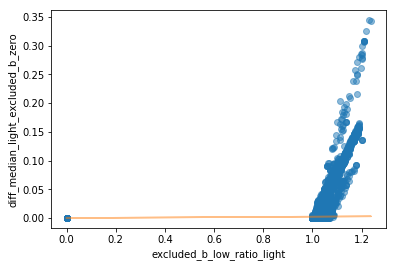

Slope: 0.00239
Standart Error: 8.29e-06
P-value: 0.0
R²: 0.0667


In [90]:
# show the corrolation between light and gcp:

def wealth_corr(df=df):

    data = df.dropna()

    # normal:
    x = data['excluded_b_low_ratio_light']
    y = data['diff_median_light_excluded_b_zero']

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept
    plt.plot(x,y,'o', x, line, alpha = 0.5)
        
    # ---------------------
    plt.xlabel('excluded_b_low_ratio_light')
    plt.ylabel('diff_median_light_excluded_b_zero')
        
    plt.show()
    print('Slope: {:.3}\nStandart Error: {:.3}\nP-value: {:.3}\nR²: {:.3}'.format(slope, std_err, p_value,r_value**2))

#     # log gcp:
#     x = data['nlights_calib_mean']
#     y = np.log(data['interp_gcp_ppp'] +1)

#     slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
#     line = slope*x+intercept
#     plt.plot(x,y,'o', x, line, alpha = 0.5)
        
#     # ---------------------
#     plt.xlabel('nlights_calib_mean')
#     plt.ylabel('log_interp_gcp_ppp')
        
#     plt.show()
#     print('Slope: {:.3}\nStandart Error: {:.3}\nP-value: {:.3}\nR²: {:.3}'.format(slope, std_err, p_value,r_value**2))
    
    
wealth_corr()

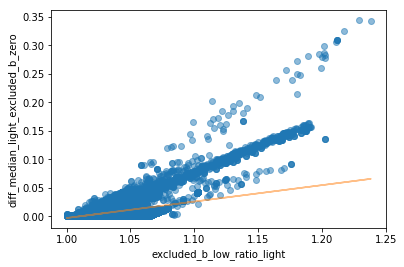

Slope: 0.289
Standart Error: 0.00099
P-value: 0.0
R²: 0.375


In [91]:
# show the corrolation between light and gcp:

def wealth_corr(df=df):

    data = df[(df['excluded_b_low_ratio_light']>0) & (df['diff_median_light_excluded_b_zero'] > 0)].dropna()

    # normal:
    x = data['excluded_b_low_ratio_light']
    y = data['diff_median_light_excluded_b_zero']

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept
    plt.plot(x,y,'o', x, line, alpha = 0.5)
        
    # ---------------------
    plt.xlabel('excluded_b_low_ratio_light')
    plt.ylabel('diff_median_light_excluded_b_zero')
        
    plt.show()
    print('Slope: {:.3}\nStandart Error: {:.3}\nP-value: {:.3}\nR²: {:.3}'.format(slope, std_err, p_value,r_value**2))

#     # log gcp:
#     x = data['nlights_calib_mean']
#     y = np.log(data['interp_gcp_ppp'] +1)

#     slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
#     line = slope*x+intercept
#     plt.plot(x,y,'o', x, line, alpha = 0.5)
        
#     # ---------------------
#     plt.xlabel('nlights_calib_mean')
#     plt.ylabel('log_interp_gcp_ppp')
        
#     plt.show()
#     print('Slope: {:.3}\nStandart Error: {:.3}\nP-value: {:.3}\nR²: {:.3}'.format(slope, std_err, p_value,r_value**2))
    
    
wealth_corr()

In [99]:
df.columns

Index(['gid', 'geometry', 'landarea', 'ttime_mean', 'mountains_mean', 'year',
       'interp_pop_gpw_sum', 'interp_gcp_ppp', 'interp_urban_ih',
       'interp_agri_ih',
       ...
       'log_diff_median_gcp_excluded_b',
       'log_diff_median_light_excluded_b_zero',
       'log_diff_median_gcp_excluded_b_zero', 'log_country_area_sum',
       'log_country_pop_sum', 'log_pop_cell_dens', 'log_pop_country_dens',
       'log_pop_cell_dens_excluded', 'log_pop_cell_dens_excluded_b',
       'lead_log_best'],
      dtype='object', length=111)

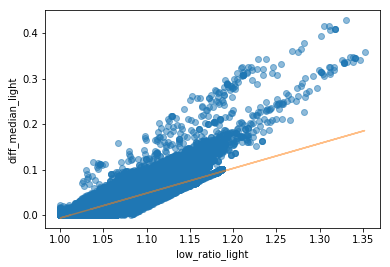

Slope: 0.546
Standart Error: 0.000884
P-value: 0.0
R²: 0.551


In [101]:
# show the corrolation between light and gcp:

def wealth_corr(df=df):

    data = df[(df['low_ratio_light']>0) & (df['diff_median_light'] > 0)].dropna()

    # normal:
    x = data['low_ratio_light']
    y = data['diff_median_light']

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept
    plt.plot(x,y,'o', x, line, alpha = 0.5)
        
    # ---------------------
    plt.xlabel('low_ratio_light')
    plt.ylabel('diff_median_light')
        
    plt.show()
    print('Slope: {:.3}\nStandart Error: {:.3}\nP-value: {:.3}\nR²: {:.3}'.format(slope, std_err, p_value,r_value**2))

#     # log gcp:
#     x = data['nlights_calib_mean']
#     y = np.log(data['interp_gcp_ppp'] +1)

#     slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
#     line = slope*x+intercept
#     plt.plot(x,y,'o', x, line, alpha = 0.5)
        
#     # ---------------------
#     plt.xlabel('nlights_calib_mean')
#     plt.ylabel('log_interp_gcp_ppp')
        
#     plt.show()
#     print('Slope: {:.3}\nStandart Error: {:.3}\nP-value: {:.3}\nR²: {:.3}'.format(slope, std_err, p_value,r_value**2))
    
    
wealth_corr()

# Så hvad er konsekvensen af et en starter på nul og en på et når du senere interagere...?

In [96]:
df[df['excluded_b_low_ratio_light'] == 0].shape

(885381, 111)

In [97]:
df[df['diff_median_light_excluded_b_zero'] == 0].shape

(1210509, 111)

# OLD:

In [90]:
selected_fetures = list(set(full_recall[3] + full_auc[3] + bs_auc[3] + bs_acc[3] + bs_recall[3]))

print(selected_fetures)
print(len(selected_fetures))

r = 5
n = len(selected_fetures)
    
N = math.factorial(n)/(math.factorial(r)*math.factorial(n-r))

print(int(N))

['ttime_mean', 'log_interp_pop_gpw_sum', 'pop_cell_dens_excluded_b', 'log_ttime_mean', 'landarea', 'log_nlights_calib_mean', 'diff_median_light_excluded_b_zero', 'excluded_b_low_ratio_light', 'mean_light', 'country_pop_sum', 'mountains_mean', 'bdist3', 'bdist1', 'log_low_ratio_light', 'log_capdist', 'interp_pop_gpw_sum', 'pop_cell_dens', 'log_bdist1', 'log_country_area_sum', 'excluded_b_pop', 'interp_agri_ih', 'log_interp_forest_ih', 'excluded_binary']
23
33649


### Should make new bs:

In [105]:
data_train_full_selected.columns

Index(['ttime_mean', 'log_interp_pop_gpw_sum', 'pop_cell_dens_excluded_b',
       'log_ttime_mean', 'landarea', 'log_nlights_calib_mean',
       'diff_median_light_excluded_b_zero', 'excluded_b_low_ratio_light',
       'mean_light', 'country_pop_sum', 'mountains_mean', 'bdist3', 'bdist1',
       'log_low_ratio_light', 'log_capdist', 'interp_pop_gpw_sum',
       'pop_cell_dens', 'log_bdist1', 'log_country_area_sum', 'excluded_b_pop',
       'interp_agri_ih', 'log_interp_forest_ih', 'excluded_binary',
       'lead_binary_best'],
      dtype='object')

In [139]:
data_train_full_selected = train_df[selected_fetures + ['lead_binary_best']].dropna().copy()
data_train_bs_selected = df_bs[selected_fetures + ['lead_binary_best']].dropna().copy()

X_full_selected = data_train_full_selected[selected_fetures].copy() # SHOULD CHANGE THESE NAMES!!!
X_bs_selected = data_train_bs_selected[selected_fetures].copy() # balanced # SHOULD CHANGE THESE NAMES!!!

y_full_selected = np.array(data_train_full_selected['lead_binary_best']) # SHOULD CHANGE THESE NAMES!!!
y_bs_selected = np.array(data_train_bs_selected['lead_binary_best']) # SHOULD CHANGE THESE NAMES!!!

In [141]:
time_start = time.time()

efs_s = efs(estimator = linear_model.LogisticRegression(), min_features=1, max_features=5, print_progress=True, scoring='roc_auc', cv=5, n_jobs=-1)

efs_s = efs_s.fit(X_bs_selected,y_bs_selected) # SHOULD CHANGE THESE NAMES!!!


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))

#bs_auc_selected = first_best(selector = efs_s)
#bs_auc_metric_selected = efs_s.get_metric_dict()

#sfs_f.subsets_

Features: 44551/44551


minutes it took: 246.893876739343



In [112]:
bs_auc_metric_selected = efs_s.get_metric_dict()


In [142]:
efs_s.best_score_

0.8135817766586593

In [143]:
efs_s.best_feature_names_

('ttime_mean',
 'log_interp_pop_gpw_sum',
 'log_ttime_mean',
 'mountains_mean',
 'bdist1')

In [144]:
efs_s.get_metric_dict()[1]

{'avg_score': 0.7781274334299059,
 'ci_bound': 0.1730783589060701,
 'cv_scores': array([0.52256929, 0.77096598, 0.9031208 , 0.85696205, 0.83701905]),
 'feature_idx': (1,),
 'feature_names': ('log_interp_pop_gpw_sum',),
 'std_dev': 0.13466084326963199,
 'std_err': 0.06733042163481599}

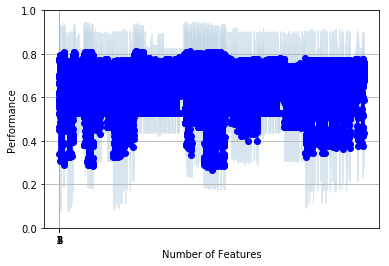

In [145]:
#plt.figure(figsize = [15,5])

plot_sfs(efs_s.get_metric_dict(), kind='std_dev')
plt.ylim([0, 1])

#plt.vlines(bs_auc_selected[0], 0, 1, 'red', 'dashed', alpha = 0.5)

#plt.title('Sequential Forward Selection (full set)')
plt.grid()
plt.show()

In [134]:
plot_sfs?

Signature: plot_sfs(metric_dict, kind='std_dev', color='blue', bcolor='steelblue', marker='o', alpha=0.2, ylabel='Performance', confidence_interval=0.95)
Docstring:
Plot feature selection results.

Parameters
----------
metric_dict : mlxtend.SequentialFeatureSelector.get_metric_dict() object
kind : str (default: "std_dev")
    The kind of error bar or confidence interval in
    {'std_dev', 'std_err', 'ci', None}.
color : str (default: "blue")
    Color of the lineplot (accepts any matplotlib color name)
bcolor : str (default: "steelblue").
    Color of the error bars / confidence intervals
    (accepts any matplotlib color name).
marker : str (default: "o")
    Marker of the line plot
    (accepts any matplotlib marker name).
alpha : float in [0, 1] (default: 0.2)
    Transparency of the error bars / confidence intervals.
ylabel : str (default: "Performance")
    Y-axis label.
confidence_interval : float (default: 0.95)
    Confidence level if `kind='ci'`.

Returns
----------
fig : mat

In [116]:
len(bs_auc_metric_selected)

33649

In [ ]:
plot_sfs(full_recall_metric, kind='std_dev')
plt.ylim([0, 1])

plt.vlines(bs_auc_selected[0], 0, 1, 'red', 'dashed', alpha = 0.5)

plt.title('Sequential Forward Selection (full set)')
plt.grid()
plt.show()

-----

In [ ]:
time_start = time.time()

efs_s = efs(estimator = linear_model.LogisticRegression(), min_features=5, max_features=5, print_progress=True, scoring='roc_auc', cv=5, n_jobs=-1)

efs_s = efs_s.fit(X_full,y_full) # SHOULD CHANGE THESE NAMES!!!


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))

bs_auc_selected = first_best(selector = efs_s) # SHOULD CHANGE THESE NAMES!!!
bs_auc_metric_selected = efs_s.get_metric_dict() # SHOULD CHANGE THESE NAMES!!!

#sfs_f.subsets_

In [ ]:
bs_auc_selected # SHOULD CHANGE THESE NAMES!!!

In [ ]:
plot_sfs(bs_auc_metric_selected, kind='std_dev')
plt.ylim([0, 1])

plt.vlines(bs_auc_selected[0], 0, 1, 'red', 'dashed', alpha = 0.5)

plt.title('Sequential Forward Selection (full set)')
plt.grid()
plt.show()

--------------
# Gammelt rod(måske/ish):

In [46]:
time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 10, forward = True, verbose = 2, scoring = 'roc_auc', cv = 5, n_jobs = 6)

#sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 'parsimonious', forward = True, verbose = 2, scoring = 'roc_auc', cv = 5, n_jobs = 6)

# men k_features = 10 er fint hvis din baysian også skal kunne køre på din puter..

sfs_f = sfs_f.fit(X,y)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))


sfs_f.subsets_

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:  7.4min finished

[2018-11-06 11:50:13] Features: 1/10 -- score: 0.8461860578120662[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done  69 out of  69 | elapsed: 10.6min finished

[2018-11-06 12:00:52] Features: 2/10 -- score: 0.9073346456658419[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done  68 out of  68 | elapsed: 11.0min finished

[2018-11-06 12:11:51] Features: 3/10 -- score: 0.9145186513641285[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done  67 out of  67 | elapsed: 11.3min finished

[2018-11-06 12:23:07] Features: 4/10 -- score: 0.9248814144017808[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done  66 out of  66 | elapsed: 15.7min finished

[2018-11-06 12:38:48] Features: 5/10 -- score: 0.9326776599344899[Parallel(n_job


minutes it took: 152.37844639619192




[2018-11-06 14:15:11] Features: 10/10 -- score: 0.9363778242910069

{1: {'avg_score': 0.8461860578120662,
  'cv_scores': array([0.99800032, 0.94187043, 0.75170051, 0.70058014, 0.83877889]),
  'feature_idx': (47,),
  'feature_names': ('log_interp_pop_gpw_sum',)},
 2: {'avg_score': 0.9073346456658419,
  'cv_scores': array([0.9989537 , 0.96366909, 0.84314603, 0.83348742, 0.89741699]),
  'feature_idx': (14, 47),
  'feature_names': ('log_best', 'log_interp_pop_gpw_sum')},
 3: {'avg_score': 0.9145186513641285,
  'cv_scores': array([0.99867502, 0.9619959 , 0.8642287 , 0.84129584, 0.9063978 ]),
  'feature_idx': (14, 47, 68),
  'feature_names': ('log_best',
   'log_interp_pop_gpw_sum',
   'log_country_area_sum')},
 4: {'avg_score': 0.9248814144017808,
  'cv_scores': array([0.99632091, 0.96229317, 0.90493296, 0.85117532, 0.90968471]),
  'feature_idx': (0, 14, 47, 68),
  'feature_names': ('landarea',
   'log_best',
   'log_interp_pop_gpw_sum',
   'log_country_area_sum')},
 5: {'avg_score': 0.9326776599344899,
  'cv_scores': array([0.9976646 , 0.95881338, 0.906959

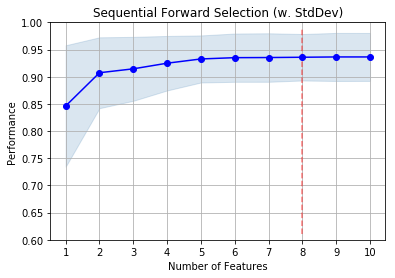

In [47]:
plot_sfs(sfs_f.get_metric_dict(), kind='std_dev')
plt.ylim([.6, 1])

plt.vlines(8, 0.61, 0.99, 'red', 'dashed', alpha = 0.5)

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [ ]:
# no pop or area sum:

In [64]:
time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 10, forward = True, verbose = 2, scoring = 'roc_auc', cv = 5, n_jobs = 6)

#sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 'parsimonious', forward = True, verbose = 2, scoring = 'roc_auc', cv = 5, n_jobs = 6)

# men k_features = 10 er fint hvis din baysian også skal kunne køre på din puter..

sfs_f = sfs_f.fit(X,y)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))


sfs_f.subsets_

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done  66 out of  66 | elapsed:  6.4min finished

[2018-11-05 20:24:19] Features: 1/10 -- score: 0.8461860578120662[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done  65 out of  65 | elapsed: 10.4min finished

[2018-11-05 20:34:41] Features: 2/10 -- score: 0.9073346456658419[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done  64 out of  64 | elapsed: 10.1min finished

[2018-11-05 20:44:45] Features: 3/10 -- score: 0.9135586503881828[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done  63 out of  63 | elapsed: 11.2min finished

[2018-11-05 20:56:01] Features: 4/10 -- score: 0.9168231594497496[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done  62 out of  62 | elapsed: 12.1min finished

[2018-11-05 21:08:06] Features: 5/10 -- score: 0.9204408122237473[Parallel(n_job


minutes it took: 153.96564529736835



[Parallel(n_jobs=6)]: Done  57 out of  57 | elapsed: 24.3min finished

[2018-11-05 22:51:50] Features: 10/10 -- score: 0.9270321003847242

{1: {'avg_score': 0.8461860578120662,
  'cv_scores': array([0.99800032, 0.94187043, 0.75170051, 0.70058014, 0.83877889]),
  'feature_idx': (47,),
  'feature_names': ('log_interp_pop_gpw_sum',)},
 2: {'avg_score': 0.9073346456658419,
  'cv_scores': array([0.9989537 , 0.96366909, 0.84314603, 0.83348742, 0.89741699]),
  'feature_idx': (14, 47),
  'feature_names': ('log_best', 'log_interp_pop_gpw_sum')},
 3: {'avg_score': 0.9135586503881828,
  'cv_scores': array([0.99866561, 0.97073744, 0.85586743, 0.8331772 , 0.90934557]),
  'feature_idx': (14, 45, 47),
  'feature_names': ('log_best', 'log_ttime_mean', 'log_interp_pop_gpw_sum')},
 4: {'avg_score': 0.9168231594497496,
  'cv_scores': array([0.99872589, 0.96806565, 0.85278471, 0.84524484, 0.9192947 ]),
  'feature_idx': (12, 14, 45, 47),
  'feature_names': ('excluded',
   'log_best',
   'log_ttime_mean',
   'log_interp_pop_gpw_sum')},
 5: {'avg_score': 0.9204408122237473,
  'cv_scores': array([0.99900478, 0.96308317, 0.86287491, 0.85214686, 0

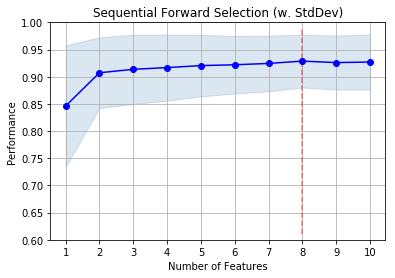

In [74]:
plot_sfs(sfs_f.get_metric_dict(), kind='std_dev')
plt.ylim([.6, 1])

plt.vlines(8, 0.61, 0.99, 'red', 'dashed', alpha = 0.5)

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

## Men du mangler stadig pop og areal for hele landet!

Prøver lige backwards: (over night og ser om den bliver færdig ;) 

In [ ]:
time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 10, forward = False, verbose = 2, scoring = 'roc_auc', cv = 5, n_jobs = -1)

#sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 'parsimonious', forward = True, verbose = 2, scoring = 'roc_auc', cv = 5, n_jobs = 6)

# men k_features = 10 er fint hvis din baysian også skal kunne køre på din puter..

sfs_f = sfs_f.fit(X,y)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))


sfs_f.subsets_

In [ ]:
plot_sfs(sfs_f.get_metric_dict(), kind='std_dev')
plt.ylim([.6, 1])

#plt.vlines(8, 0.61, 0.99, 'red', 'dashed', alpha = 0.5)

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

----

In [84]:
time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 10, forward = True, verbose = 2, scoring = 'roc_auc', cv = 5, n_jobs = 6)

#sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 'parsimonious', forward = True, verbose = 2, scoring = 'roc_auc', cv = 5, n_jobs = 6)

# men k_features = 10 er fint hvis din baysian også skal kunne køre på din puter..

sfs_f = sfs_f.fit(X,y)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))


sfs_f.subsets_

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done  59 out of  59 | elapsed:  6.4min finished

[2018-11-03 11:55:13] Features: 1/10 -- score: 0.8461860578120662[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done  58 out of  58 | elapsed: 10.4min finished

[2018-11-03 12:05:36] Features: 2/10 -- score: 0.8729457947102354[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done  57 out of  57 | elapsed: 11.5min finished

[2018-11-03 12:17:06] Features: 3/10 -- score: 0.8821109908329667[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done  56 out of  56 | elapsed: 17.8min finished

[2018-11-03 12:34:56] Features: 4/10 -- score: 0.8877949880607046[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 12.1min
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed: 21.6min finished

[2018-11-03 12:56:32] Features: 5/10 -- score: 0.890347370718993[Parallel(n_jobs


minutes it took: 205.7031649629275




[2018-11-03 15:14:33] Features: 10/10 -- score: 0.8942867882248423

{1: {'avg_score': 0.8461860578120662,
  'cv_scores': array([0.99800032, 0.94187043, 0.75170051, 0.70058014, 0.83877889]),
  'feature_idx': (38,),
  'feature_names': ('log_interp_pop_gpw_sum',)},
 2: {'avg_score': 0.8729457947102354,
  'cv_scores': array([0.99762401, 0.95253457, 0.80651904, 0.73450157, 0.87354978]),
  'feature_idx': (25, 38),
  'feature_names': ('excluded_b_gcp', 'log_interp_pop_gpw_sum')},
 3: {'avg_score': 0.8821109908329667,
  'cv_scores': array([0.99885997, 0.93962658, 0.83373752, 0.75815116, 0.88017973]),
  'feature_idx': (11, 25, 38),
  'feature_names': ('capdist', 'excluded_b_gcp', 'log_interp_pop_gpw_sum')},
 4: {'avg_score': 0.8877949880607046,
  'cv_scores': array([0.99861281, 0.94431414, 0.84888642, 0.77221824, 0.87494333]),
  'feature_idx': (10, 11, 25, 38),
  'feature_names': ('bdist3',
   'capdist',
   'excluded_b_gcp',
   'log_interp_pop_gpw_sum')},
 5: {'avg_score': 0.890347370718993,
  'cv_scores': array([0.99751668, 0.94321331, 0.85360351, 0.7788355 , 

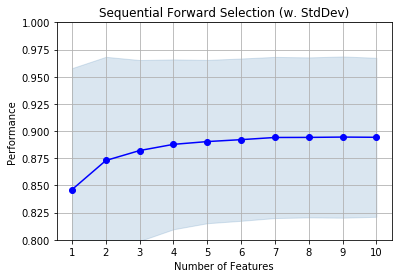

In [85]:
plot_sfs(sfs_f.get_metric_dict(), kind='std_dev')
plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

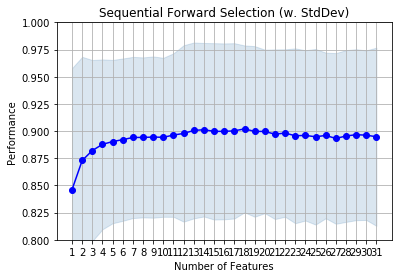

In [72]:
plot_sfs(sfs_f.get_metric_dict(), kind='std_dev')
plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()



### K = 10

In [66]:
time_start = time.time()

#sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 'best', forward = True, verbose = 2, scoring = 'roc_auc', cv = 5, n_jobs = -1)
sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 10, forward = True, verbose = 2, scoring = 'roc_auc', cv = 5, n_jobs = 6)

# men k_features = 10 er fint hvis din baysian også skal kunne køre på din puter..

sfs_f = sfs_f.fit(X,y)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))


sfs_f.subsets_


#print('Best auc_roc score: %.2f' % sfs_f.best_score_)
#print('Best subset (indices):', sfs_f.best_idx_)
#print('Best subset (corresponding names):', sfs_f.best_feature_names_)

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done  56 out of  56 | elapsed:  5.6min finished

[2018-11-02 12:08:15] Features: 1/10 -- score: 0.8461860578120662[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed:  8.6min finished

[2018-11-02 12:16:52] Features: 2/10 -- score: 0.8729457947102354[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done  54 out of  54 | elapsed:  9.4min finished

[2018-11-02 12:26:15] Features: 3/10 -- score: 0.8821109908329667[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done  53 out of  53 | elapsed: 14.9min finished

[2018-11-02 12:41:12] Features: 4/10 -- score: 0.8877949880607046[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done  52 out of  52 | elapsed: 17.5min finished

[2018-11-02 12:58:42] Features: 5/10 -- score: 0.890347370718993[Parallel(n_jobs


minutes it took: 171.25306013822555




[2018-11-02 14:53:53] Features: 10/10 -- score: 0.8942867882248423

{1: {'avg_score': 0.8461860578120662,
  'cv_scores': array([0.99800032, 0.94187043, 0.75170051, 0.70058014, 0.83877889]),
  'feature_idx': (38,),
  'feature_names': ('log_interp_pop_gpw_sum',)},
 2: {'avg_score': 0.8729457947102354,
  'cv_scores': array([0.99762401, 0.95253457, 0.80651904, 0.73450157, 0.87354978]),
  'feature_idx': (25, 38),
  'feature_names': ('excluded_b_gcp', 'log_interp_pop_gpw_sum')},
 3: {'avg_score': 0.8821109908329667,
  'cv_scores': array([0.99885997, 0.93962658, 0.83373752, 0.75815116, 0.88017973]),
  'feature_idx': (11, 25, 38),
  'feature_names': ('capdist', 'excluded_b_gcp', 'log_interp_pop_gpw_sum')},
 4: {'avg_score': 0.8877949880607046,
  'cv_scores': array([0.99861281, 0.94431414, 0.84888642, 0.77221824, 0.87494333]),
  'feature_idx': (10, 11, 25, 38),
  'feature_names': ('bdist3',
   'capdist',
   'excluded_b_gcp',
   'log_interp_pop_gpw_sum')},
 5: {'avg_score': 0.890347370718993,
  'cv_scores': array([0.99751668, 0.94321331, 0.85360351, 0.7788355 , 

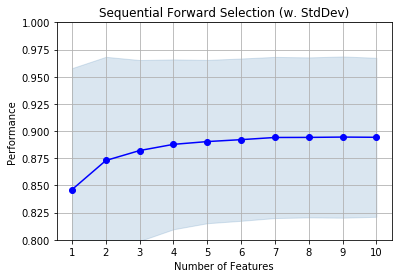

In [68]:
plot_sfs(sfs_f.get_metric_dict(), kind='std_dev')
plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()



# Hvis nu der er nogle af dine smarte interaktioner eller log'er der ikke kommer med kan du jo overveje at lade være med at konstruere dem til at starte med...

Især skal du lige kikke på dine logs igen.... Der er meget at spare
Og så køre du slef med alle fire:

## det er intersant men conflict variabler ne burde også komme med....

# EKS:

In [ ]:
# Sequential Forward Selection
sfs = SFS(knn, 
          k_features=3, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=4,
          n_jobs=-1)
sfs = sfs.fit(X, y)

print('\nSequential Forward Selection (k=3):')
print(sfs.k_feature_idx_)
print('CV Score:')
print(sfs.k_score_)

###################################################

# Sequential Backward Selection
sbs = SFS(knn, 
          k_features=3, 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          cv=4,
          n_jobs=-1)
sbs = sbs.fit(X, y)

print('\nSequential Backward Selection (k=3):')
print(sbs.k_feature_idx_)
print('CV Score:')
print(sbs.k_score_)

###################################################

# Sequential Forward Floating Selection
sffs = SFS(knn, 
           k_features=3, 
           forward=True, 
           floating=True, 
           scoring='accuracy',
           cv=4,
           n_jobs=-1)
sffs = sffs.fit(X, y)

print('\nSequential Forward Floating Selection (k=3):')
print(sffs.k_feature_idx_)
print('CV Score:')
print(sffs.k_score_)

###################################################

# Sequential Backward Floating Selection
sbfs = SFS(knn, 
           k_features=3, 
           forward=False, 
           floating=True, 
           scoring='accuracy',
           cv=4,
           n_jobs=-1)
sbfs = sbfs.fit(X, y)

print('\nSequential Backward Floating Selection (k=3):')
print(sbfs.k_feature_idx_)
print('CV Score:')
print(sbfs.k_score_)


In [ ]:
time_start = time.time()

sfs_b = sfs(estimator = linear_model.LogisticRegression(), k_features= 'best', forward = False, verbose = 2, scoring = 'roc_auc', cv = 5, n_jobs = -1)

sfs_b = sfs_b.fit(X,y)

time_stop = time.time()
time_to_finish = time_stop - time_start

print('minutes it took: ' + str(time_to_finish/60))

print('Best roc_auc score: %.2f' % sfs_b.best_score_)
print('Best subset (indices):', sfs_b.best_idx_)
print('Best subset (corresponding names):', sfs_b.best_feature_names_)

---
# REST/ ROD:

In [34]:
time_start = time.time()

#from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.feature_selection import ExhaustiveFeatureSelector as efs
from sklearn.model_selection import train_test_split
from sklearn import linear_model

from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, classification_report, precision_score, recall_score

#logit = linear_model.LogisticRegression()

data = df.dropna().copy()

X = np.array(data[['gid', 'landarea', 'ttime_mean', 'mountains_mean', 'year',
       'interp_pop_gpw_sum', 'interp_gcp_ppp', 'interp_urban_ih',
       'interp_agri_ih', 'interp_forest_ih', 'gwno', 'gwarea', 'bdist1',
       'bdist3', 'capdist', 'excluded', 'nlights_calib_mean', 'best',
       'log_best', 'petroleum_full', 'binary_best',
       'past_fatalities', 'past_conflicts', 'log_landarea', 'log_ttime_mean',
       'log_mountains_mean', 'log_interp_pop_gpw_sum', 'log_interp_gcp_ppp',
       'log_interp_urban_ih', 'log_interp_agri_ih', 'log_interp_forest_ih',
       'log_gwarea', 'log_bdist1', 'log_bdist3', 'log_capdist', 'log_excluded',
       'log_nlights_calib_mean', 'log_past_fatalities', 'log_past_conflicts']])

y = np.array(data['lead_binary_best'])

efs1 = efs(estimator = linear_model.LogisticRegression(), min_features = 1, max_features = X.shape[1], 
           print_progress = True, scoring = 'roc_auc', cv = 5, n_jobs = -1)

efs1 = efs1.fit(X,y)


# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

# logit.fit(X_train, y_train)

time_stop = time.time()
time_to_finish = time_stop - time_start

print('minutes it took: ' + str(time_to_finish/60))

print('Best f1 score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

KeyboardInterrupt: 

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']

# Men den er meget unbalanced... Det kan være du skal gøre noget ved det først..

In [ ]:
efs1 = efs(estimator = linear_model.LinearRegression(), min_features = 1, max_features = len(feature_list_2)-1, 
           print_progress = True, scoring = 'neg_mean_squared_error', cv = 5, n_jobs = -1)

data = df[feature_list_2].dropna().copy()

X = np.array(data[feature_list_2[1:]])

y = np.array(np.log(data['interp_gcp_ppp']+1))

efs1 = efs1.fit(X,y)

print('Best mean_squared_error score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

In [19]:
# Skabelon:

# prøv både med log(y) og y for at se hvad der er bedst:

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

data = df[['nlights_calib_mean','interp_gcp_ppp','year']].dropna().copy()

X = np.array(data[['nlights_calib_mean','year']])

y = np.array(data['interp_gcp_ppp'])

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

#Plot outputs
plt.scatter(X_test[:,0], y_test,  color='black', alpha = 0.1)
plt.plot(X_test[:,0], y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

NameError: name 'train_test_split' is not defined

# OLD:
## All good and nice... But..
Is you y not dicotomus?

In [37]:
# Should proberly come a lot earlier:

df['binary_best'] = pd.Series(df_s['best'] > 0).astype('int') 

df_s = df.sample(10000, random_state=123)

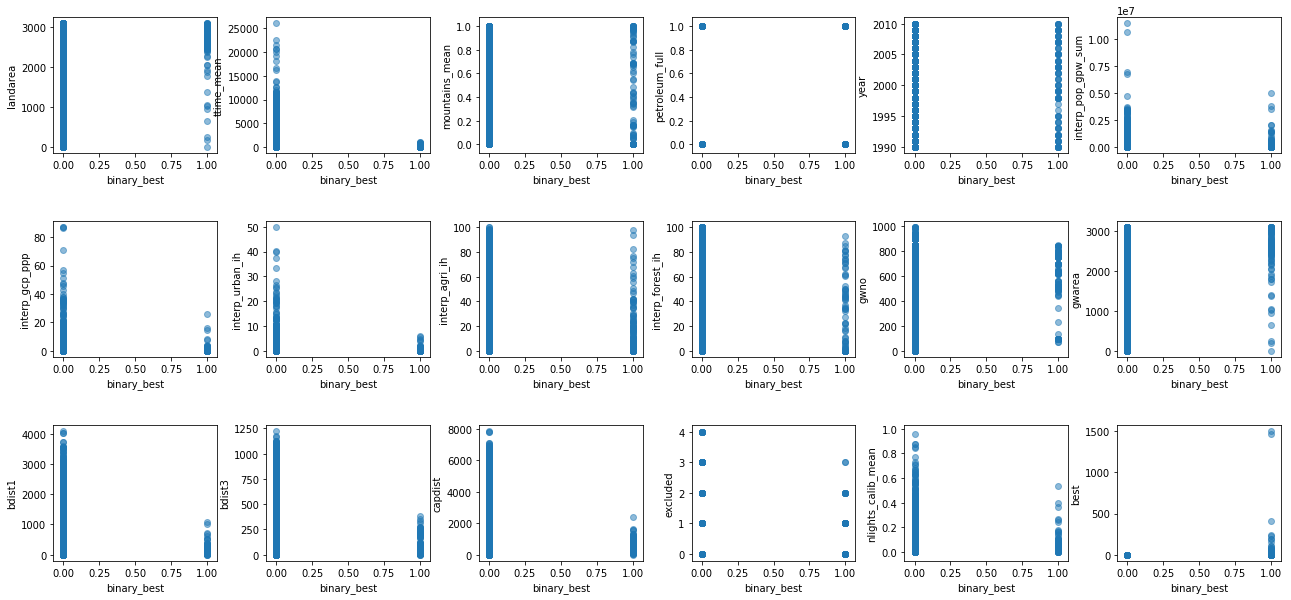

In [41]:
def mass_scatter_ybinary(df=df_s):
    
    
    nfeatures = len(feature_list)
    cols=6 
    rows=math.ceil(nfeatures/cols)
    
    fig = plt.figure(figsize = (22,10))
    fig.subplots_adjust(hspace = 0.5, wspace = 0.3)
        
    for i in np.arange(nfeatures):
        plot_n = i+1

        plt.subplot(rows,cols,plot_n)
        plt.scatter(data=df[[feature_list[i],'binary_best']].dropna(), y=feature_list[i], x='binary_best',alpha = 0.5)
        plt.ylabel(feature_list[i])
        plt.xlabel('binary_best')
        
    plt.show()

mass_scatter_ybinary()

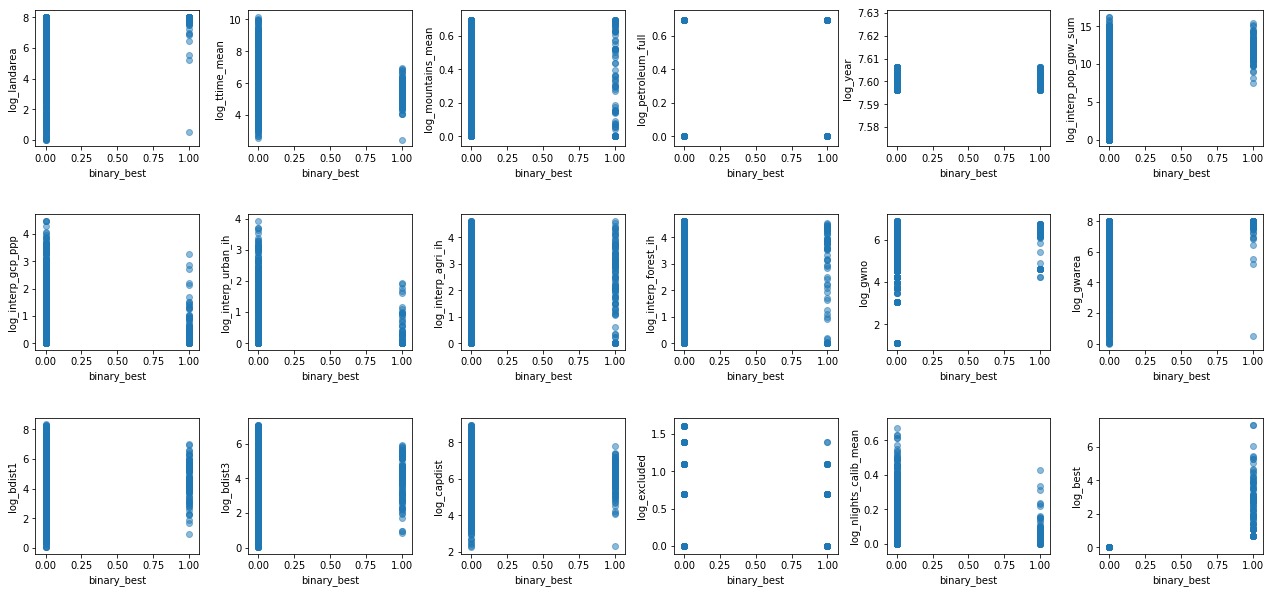

In [39]:
def mass_scatter_ybinary_xlog(df=df_s):
      
    nfeatures = len(log_feature_list)
    cols=6 
    rows=math.ceil(nfeatures/cols)
    
    fig = plt.figure(figsize = (22,10))
    fig.subplots_adjust(hspace = 0.5, wspace = 0.3)
        
    for i in range(nfeatures):
        plot_n = i + 1
        plt.subplot(rows,cols,plot_n)
                
        #log_feature = np.log(df[feature_list[i-1]] + 1)
                
        plt.scatter(data=df[[log_feature_list[i],'binary_best']].dropna(), y=log_feature_list[i], x='binary_best',alpha = 0.5)
        plt.ylabel(log_feature_list[i])
        plt.xlabel('binary_best')
        
    plt.show()

mass_scatter_ybinary_xlog()

Not as informative, but the point is made. Now feature selection:
Wait. You do need to construct a number of other features and 'lead' you y.... Shoul you also you should check for qudratic and interaction terms using some econometric trick...

In [43]:
df.columns

Index(['gid', 'geometry', 'landarea', 'ttime_mean', 'mountains_mean', 'year',
       'interp_pop_gpw_sum', 'interp_gcp_ppp', 'interp_urban_ih',
       'interp_agri_ih', 'interp_forest_ih', 'gwno', 'gwarea', 'bdist1',
       'bdist3', 'capdist', 'excluded', 'nlights_calib_mean', 'best',
       'log_best', 'petroleum_full', 'log_landarea', 'log_ttime_mean',
       'log_mountains_mean', 'log_petroleum_full', 'log_year',
       'log_interp_pop_gpw_sum', 'log_interp_gcp_ppp', 'log_interp_urban_ih',
       'log_interp_agri_ih', 'log_interp_forest_ih', 'log_gwno', 'log_gwarea',
       'log_bdist1', 'log_bdist3', 'log_capdist', 'log_excluded',
       'log_nlights_calib_mean', 'best_binary', 'binary_best'],
      dtype='object')

Vairables construct:

- Counts of past conflicts 
- Years since last conflict 
    - der er nogle der gør det her på en smart måde, men du vil jo gerne hvade det ind som en continuelig del af heirarkiet.. og så er det vel en funciton af log_best??
- Some gaussian trick? The curve? or pridicted value...

- and lead the y...

### Lead y:

In [74]:
# Simple proof of concept:

d = {'Group' : ['A','A','A','B','B'] ,'data': [1, 2, 3, 4, 5], 'year': [1900, 1901, 1902, 1900, 1901]}

test_df = pd.DataFrame(data=d)

test_df['lagged_data'] = test_df.groupby(['Group'])['data'].shift(1)
test_df['lead_data'] = test_df.groupby(['Group'])['data'].shift(-1)

test_df

,Group,data,year,lagged_data,lead_data
0,A,1,1900,NaN,2.0
1,A,2,1901,1.0,3.0
2,A,3,1902,2.0,NaN
3,B,4,1900,NaN,5.0
4,B,5,1901,4.0,NaN


In [76]:
# Simple proof of concept with un-ordered years:

d = {'Group' : ['A','A','A','B','B'] ,'data': [2, 1, 3, 5, 4], 'year': [1901, 1900, 1902, 1901, 1900]}

test_df = pd.DataFrame(data=d)

test_df['lagged_data'] = test_df.sort_values('year').groupby(['Group'])['data'].shift(1)
test_df['lead_data'] = test_df.sort_values('year').groupby(['Group'])['data'].shift(-1)

test_df.sort_values(['Group','year'])

# works fine.

,Group,data,year,lagged_data,lead_data
1,A,1,1900,NaN,2.0
0,A,2,1901,1.0,3.0
2,A,3,1902,2.0,NaN
4,B,4,1900,NaN,5.0
3,B,5,1901,4.0,NaN


In [70]:
# Måske op meget tidligere?
df['lead_binary_best'] = df.sort_values('year').groupby(['gid'])['binary_best'].shift(-1)

### Counts of past conflicts:

In [78]:
# Simple proof of concept:

d = {'Group' : ['A','A','A','B','B'] ,'data': [1, 2, 3, 4, 5], 'year': [1900, 1901, 1902, 1900, 1901]}

test_df = pd.DataFrame(data=d)

test_df['comsum_data'] = test_df.groupby(['Group'])['data'].cumsum()


test_df

,Group,data,year,comsum_data
0,A,1,1900,1
1,A,2,1901,3
2,A,3,1902,6
3,B,4,1900,4
4,B,5,1901,9


In [79]:
# Simple proof of concept with un-ordered years:

d = {'Group' : ['A','A','A','B','B'] ,'data': [2, 1, 3, 5, 4], 'year': [1901, 1900, 1902, 1901, 1900]}

test_df = pd.DataFrame(data=d)

test_df['cumsum_data'] = test_df.sort_values('year').groupby(['Group'])['data'].cumsum()

test_df.sort_values(['Group','year'])

# works fine. You just need to open your eyes ;) 

,Group,data,year,cumsum_data
1,A,1,1900,1
0,A,2,1901,3
2,A,3,1902,6
4,B,4,1900,4
3,B,5,1901,9


In [80]:
df['past_fatalities'] = df.sort_values('year').groupby(['gid'])['best'].cumsum()

df['log_past_fatalities'] = np.log(df['past_fatalities'] + 1)

df['past_conflicts'] = df.sort_values('year').groupby(['gid'])['binary_best'].cumsum()

### years since last conflict:

this will be prblematic for cuntries with no conflicts, or for observations before conflict. Turn it the other way around and the problem is smaller but stille there.

---

# To come: 

In [ ]:
#from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.feature_selection import ExhaustiveFeatureSelector as efs
from sklearn.model_selection import train_test_split
from sklearn import linear_model

from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, classification_report, precision_score, recall_score

logit = linear_model.LogisticRegression()

data = df.dropna().copy()

X = np.array(data[['gid', 'landarea', 'ttime_mean', 'mountains_mean', 'year', 'interp_pop_gpw_sum', 'interp_gcp_ppp', 'interp_urban_ih',
                   'interp_agri_ih', 'interp_forest_ih', 'gwno', 'gwarea', 'bdist1','bdist3', 'capdist', 'excluded', 'nlights_calib_mean', 'best',
                   'log_best', 'petroleum_full', 'log_landarea', 'log_ttime_mean', 'log_mountains_mean', 'log_petroleum_full', 'log_interp_pop_gpw_sum',
                   'log_interp_gcp_ppp', 'log_interp_urban_ih', 'log_interp_agri_ih', 'log_interp_forest_ih', 'log_gwarea', 'log_bdist1', 'log_bdist3', 
                   'log_capdist','log_nlights_calib_mean', 'best', 'log_best']])

y = np.array(data['lead_binary_best'])


In [ ]:
# prøv både med log(y) og y for at se hvad der er bedst:

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

data = df[['nlights_calib_mean','interp_gcp_ppp','year']].dropna().copy()

X = np.array(data[['nlights_calib_mean','year']])

y = np.array(data['interp_gcp_ppp'])

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

#Plot outputs
plt.scatter(X_test[:,0], y_test,  color='black', alpha = 0.1)
plt.plot(X_test[:,0], y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()


**Så du kan tager en (log for visualisering) var af gangen og interpolere Nan's. så plotter du kortet og ser om det virker realistisk**

bdist skal måske bare sættes til nan = maks så ø-staterne kommer med.

But that is not yet.... 